# Machine Learning for Counterterrorism

**Authors:** Akhil Jalan, Yakub Akhmerov, Paul Kim

{akhiljalan, yakubakh, luapkim} @berkeley.edu

# Abstract

Terrorism, defined broadly as "the use of intentionally indiscriminate violence as a means to create terror, or fear, to achieve a political, religious or ideological aim" (Wikipedia), is a defining global challenge in the 21st century. In order to assist the fight against terrorism, the University of Maryland's Department of Homeland Security Center of Excellence compiled an extensive and rich database of international terrorist attacks from 1970 to 2016, to be used for analysis and data science purposes. 

In order to inform counterterrorism strategy, we sought to answer a critical question: **what factors are most influential in determining whether a terrorist attack succeeds or fails?** Armed with this information, counterterrorist organizations would be better able to prioritize their foci for further research and training. 

# Introduction

## Preprocessing

The raw data came in the form of two large csv files, with a total of 170350 entries spanning 135 variables with information on the date, attack type, location, tactics, perpetrating groups, targets, and outcomes. 

In order to preprocess the data, we made a Python file with convenient preprocessing functions that could be run at the start of each analysis notebook. These preprocessing functions loaded raw csv data into a Pandas dataframe, dropped unused columns or columns with a large number of NaNs ("Not a Number" values which represent missing data), and created one-hot-encoded dummy variables from the important categorical features. Note that since we used a one-hot encoding, our vectors are *sparse*: most of their entries are 0. 

This workflow was not the only possible one. We could have made a separate notebook that, when executed, outputted the cleaned data and saved it to file, which could then be loaded in subsequent notebooks. However, because all three of us had different workflows and the overall structure of the project was not sequential, we felt this would lead to unnecessary complications. The models in our analyses each used slightly different subsets of the data, and as such it makes more sense to preprocess the data separately for each model. 

## Analysis

Roughly, our analysis falls into one of two categories **exploration** and **prediction**. In exploratory analysis, we sought to understand the underlying patterns and trends in the data via various shallow computations and visualizations. In predictive analysis, we built statistical models to predict whether a given terrorist 

# Exploration

In this section, we explain some of the most informative results of our exploratory analysis. While these analyses did not model sucess/failure rates of terrorist attacks, they were essential to informing our choice of models and variables. Moreover, in a database with over 100 variables, it was necessary to make sense of what information was meaningful and what could be left out. 

## Basic Trends

Next the count of attacks over years. We grouped by year and attack type and renamed to count. The result was a multi-indexed pandas dataframe with 2 levels of indexing, year and attack type. Multi-indexed data frames don't have the easiest properties to work with with but fortunately, a pandas webpage provided assistance with that, the page is referenced in the notebook (counter_terrorism_nb3). An analysis of trends different terrorist groups is also in said notebook (Taliban, SL, Al-Shabaab, and IRA).

The trends all have pretty similar levels through the years with the exception of Armed Assault and Bombing/Explosions. With massive spikes in the mid 2000's. Clearly terrorism has risen in the last 15 years and thus a clear issue.

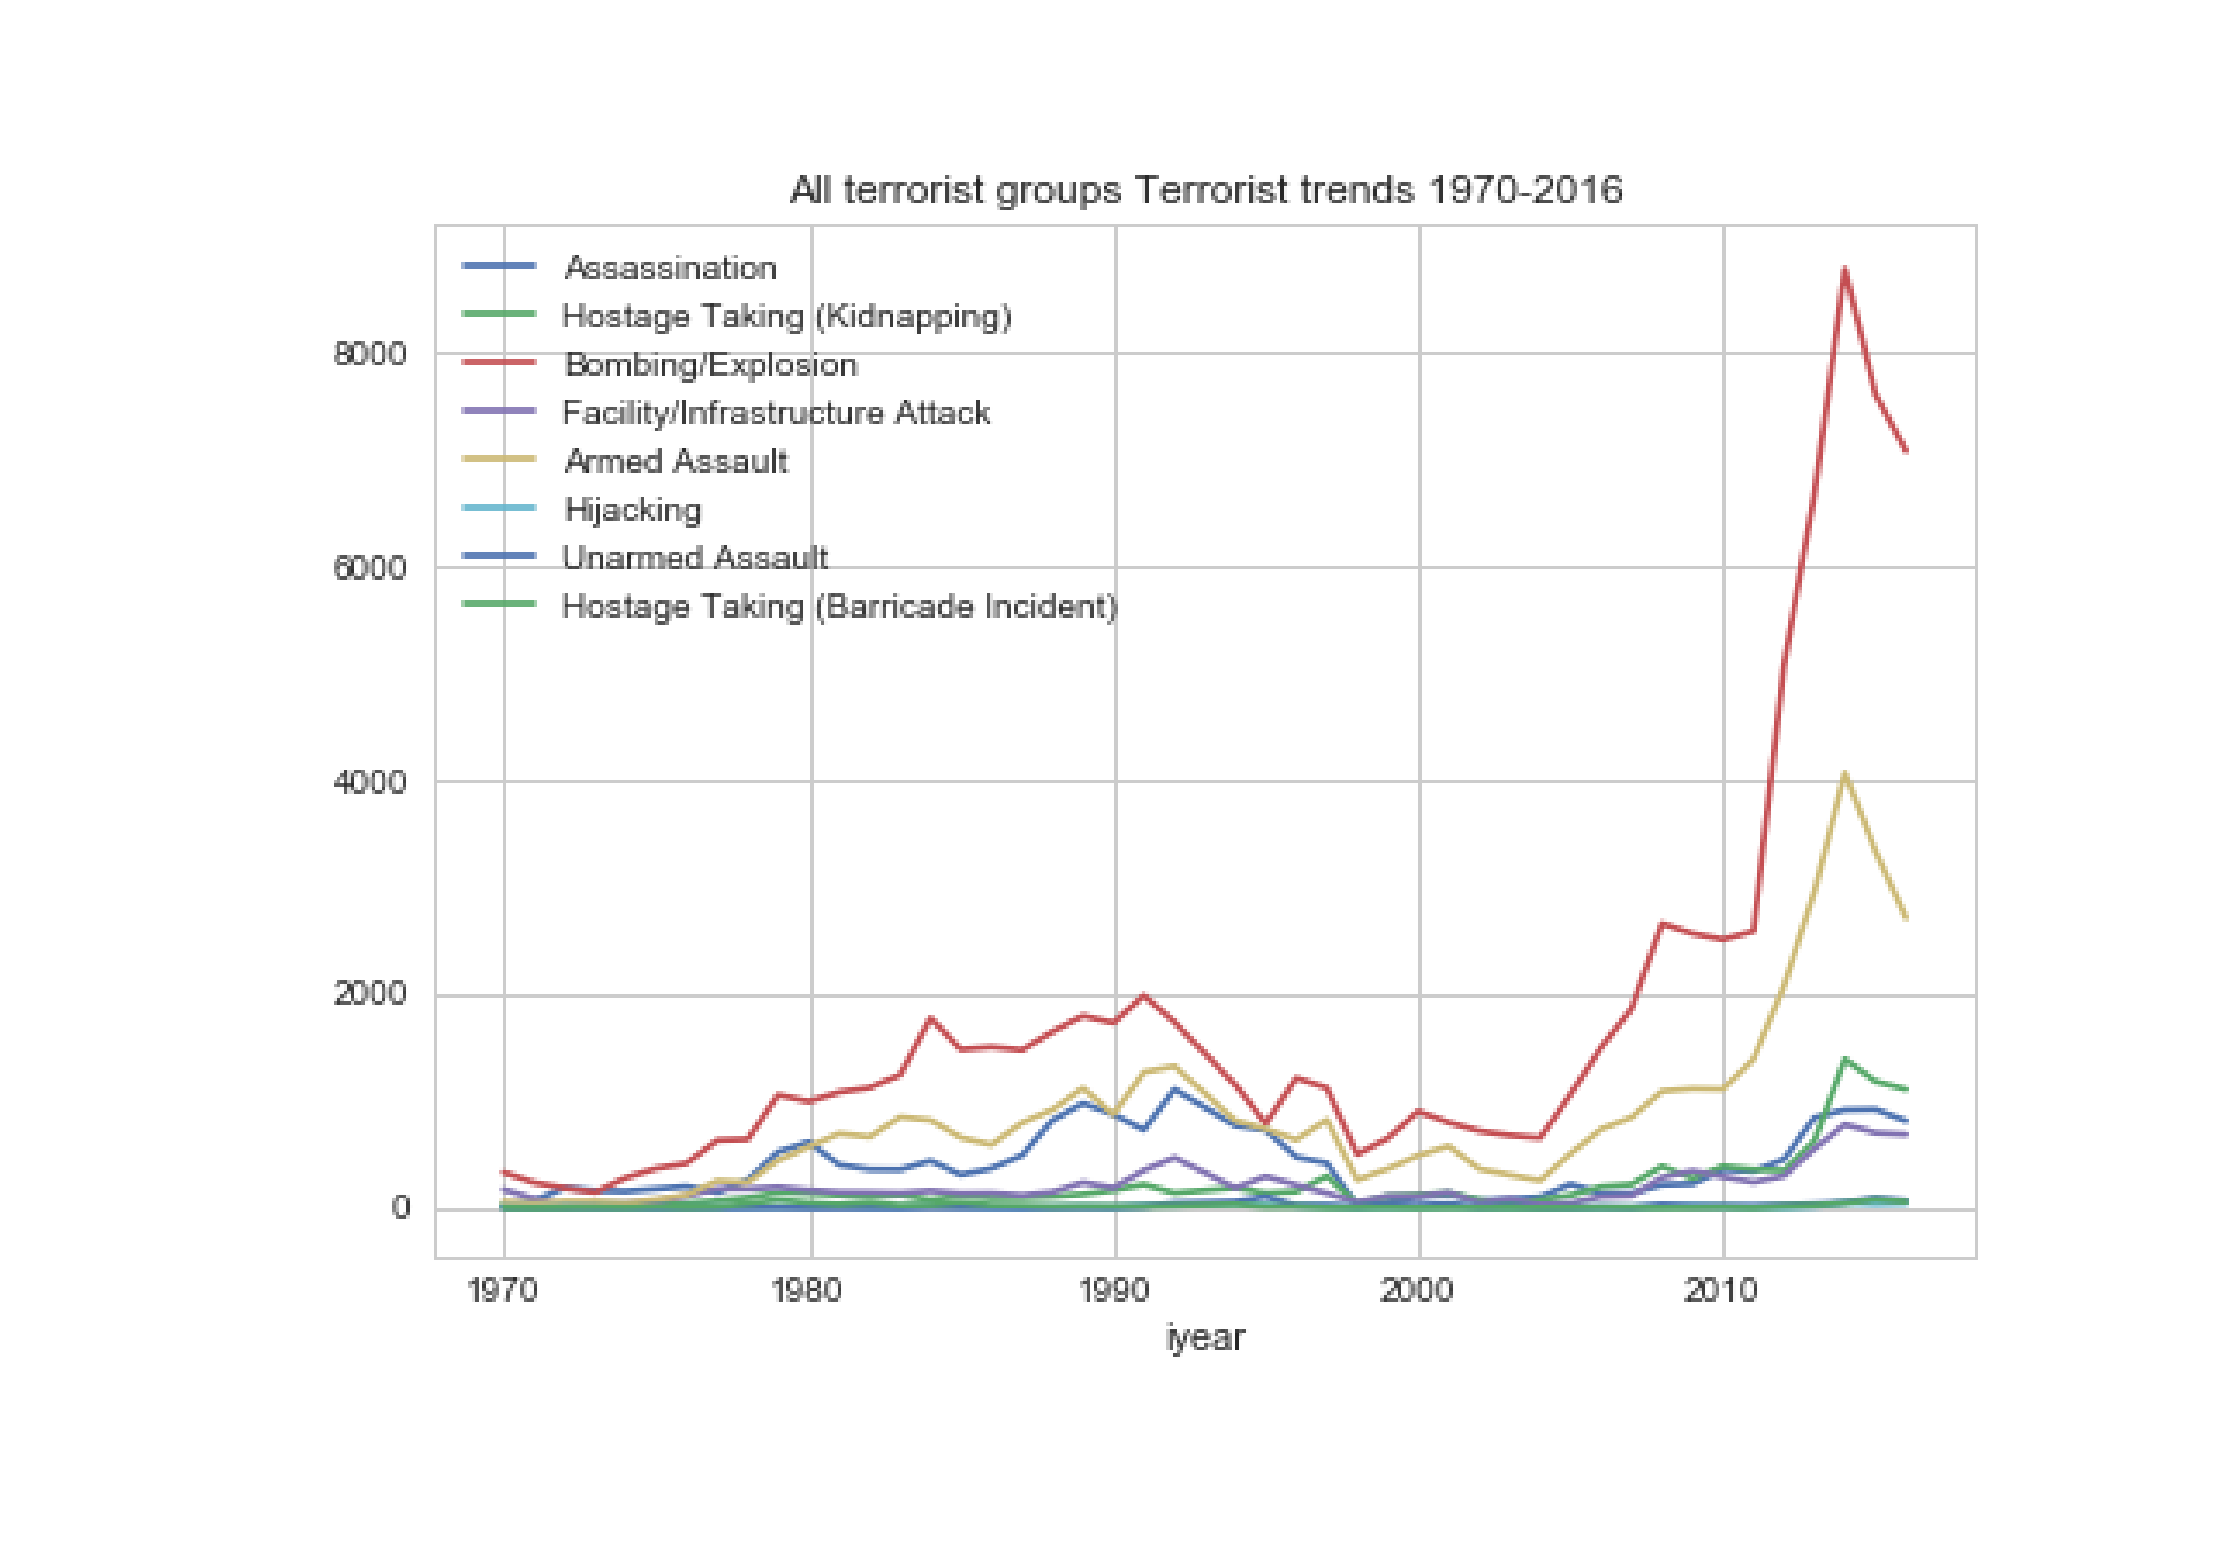

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.figure as fig
%matplotlib inline

def display_image(filepath): 
    '''
    Displays an image from file. 
    filepath: A string corresponding to the filepath of the image. 
    '''
    assert 'figures/' in filepath, 'Wrong filepath'
    assert '.png' in filepath, 'Filename does not contain .png'
    
    plt.rcParams['figure.dpi']= 400
    img = mpimg.imread(filepath)
    #, interpolation='nearest', aspect="auto"
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

display_image('figures/all_trends.png')

## Geographic Visualizations 



Due to having GPS coordinates for the terrorist attack, a visual representation of the attacks would be fitting. A few actions had to be taken to get the idea into an actual plot.:

1. From a previous notebook, we found the top 5 terrorist groups responsible for the most groups. We wanted the data visualization to reflect this information.
2. A helper function was made "group_to_color" to map the colors of the terrorists groups. 
3. creating a function to plot the data. Basemap and matplot lib were used.
4. The creation of the plots was then done, A plot of the world, the United States of America, Iraq, Afghanistan, Pakistan, and South America to show the various levels of terrorist activity in these various parts of the world.

The results show just how much of a global problem terrorism is. With the top 5 terrorist groups being concentrated in their respective areas. An in-depth look in some of the specific regions are in notebook 3.

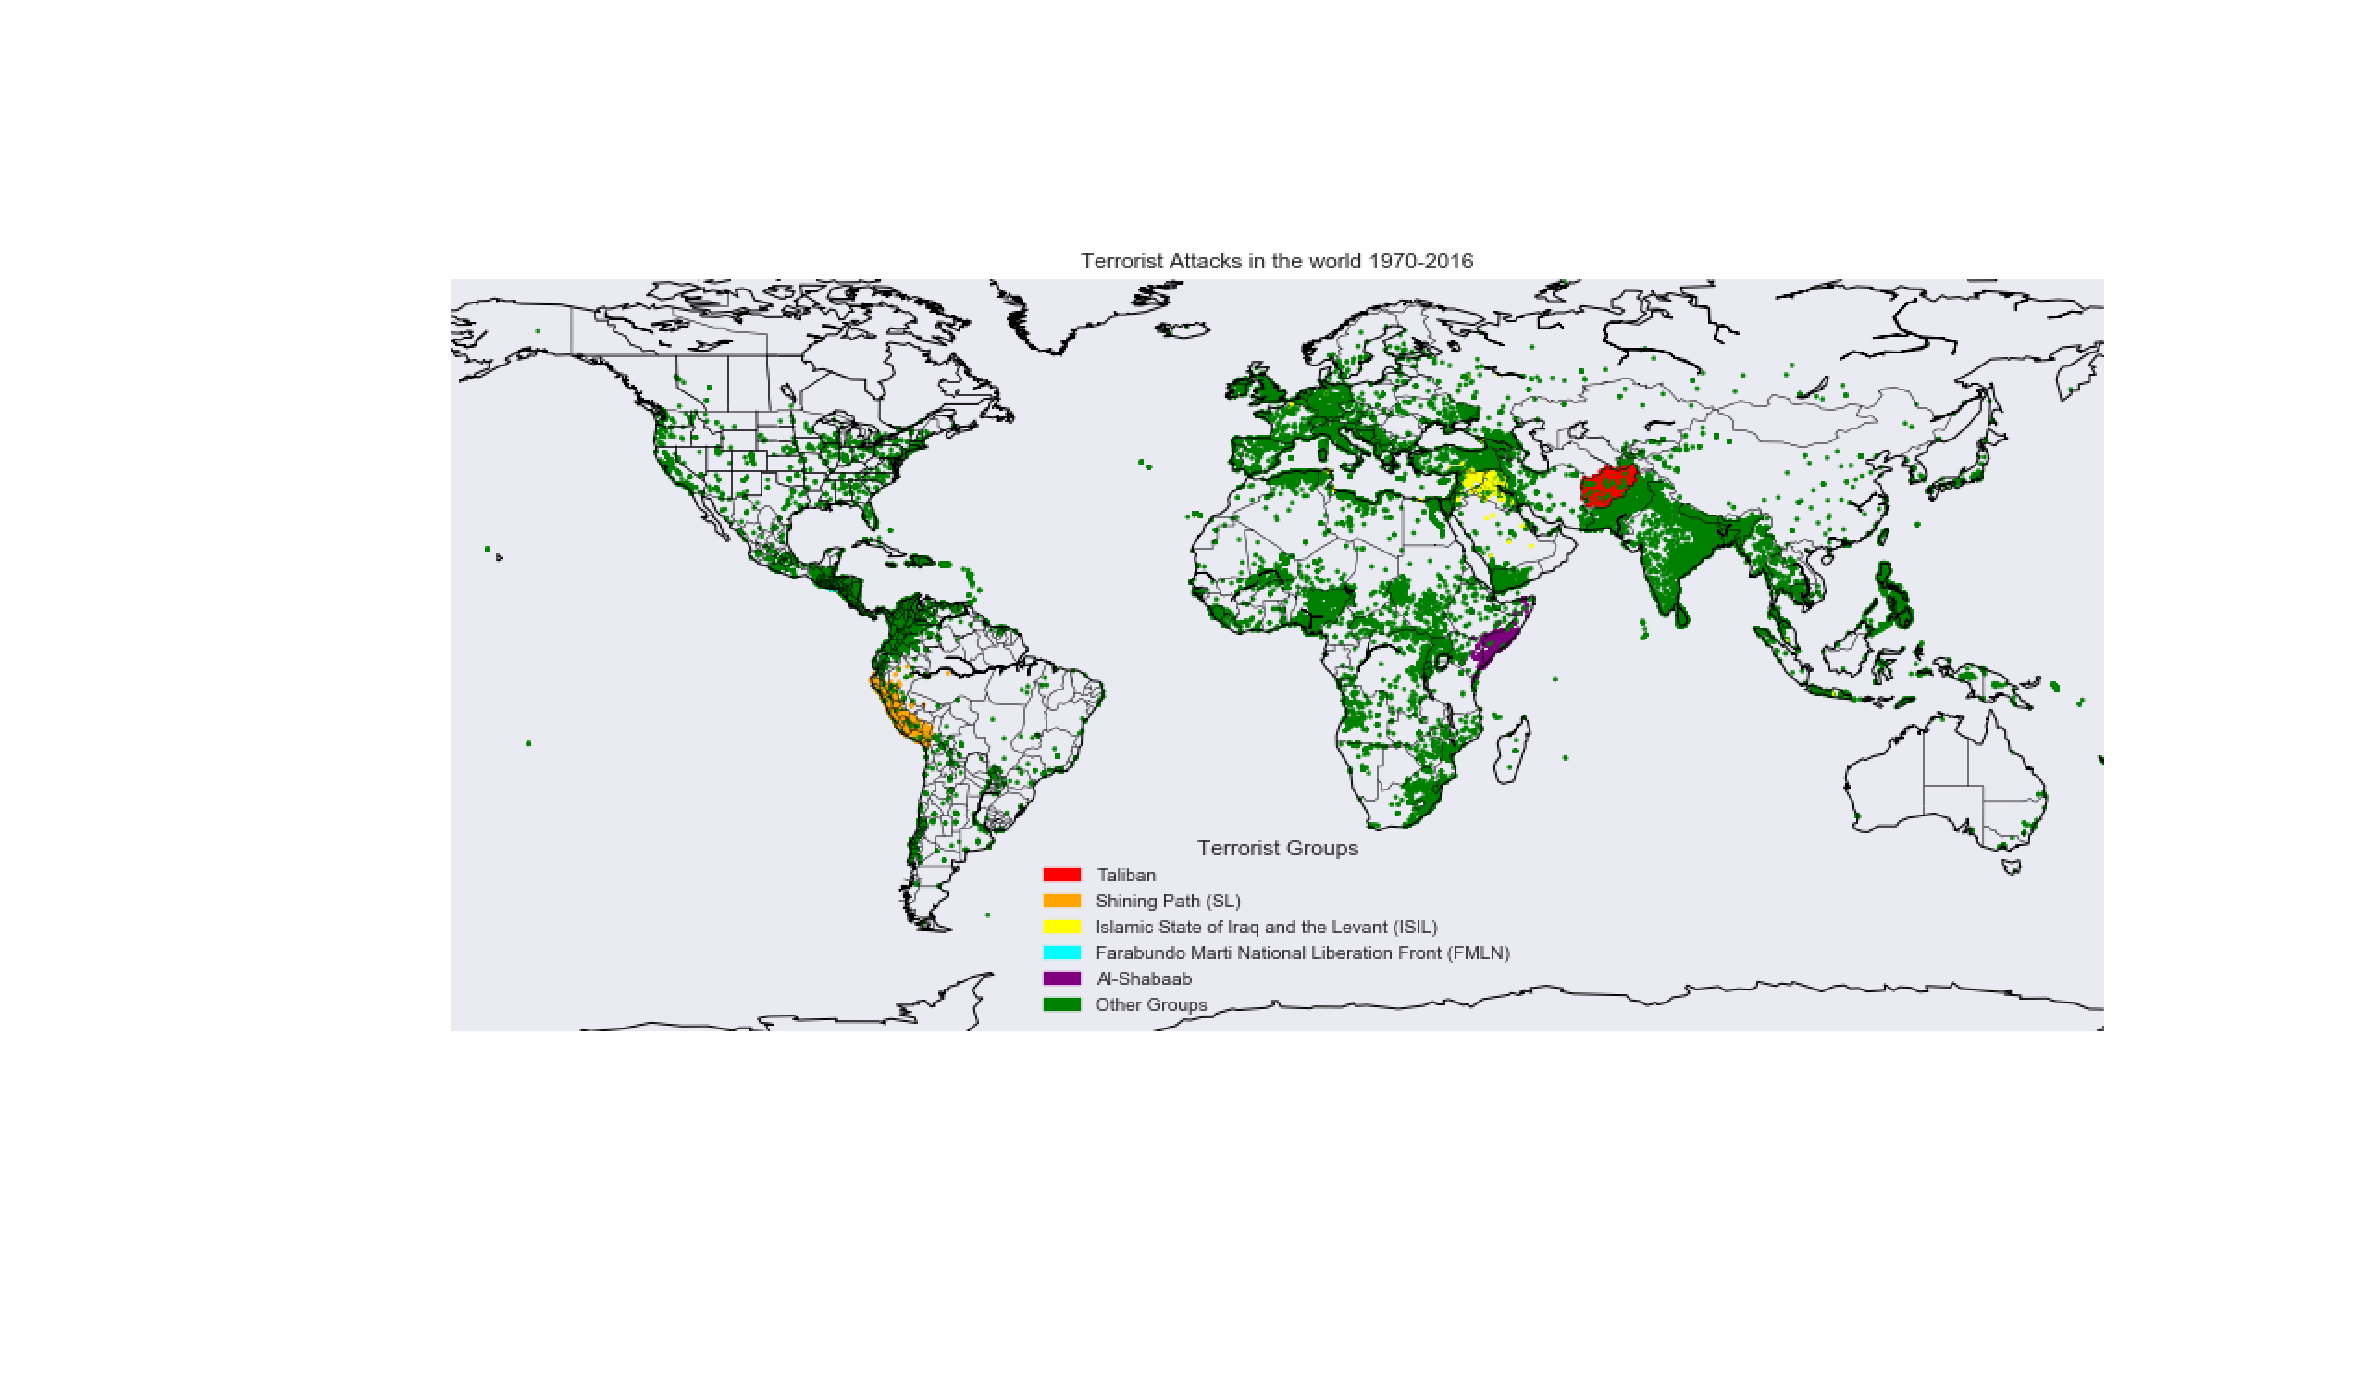

In [16]:
display_image('figures/global_terrorism_gps.png')

## Affinity Maps

We use the term **affinity map** to refer to a heatmap which displays the 'distance' between different categories in a trait of interest. For example, we might want to understand the level of similarity between terrorist attacks which use chemical weapons and those which use explosives. 

How should one measure this similarity? Given that we have used a one-hot encoding of the data, each terrorist attack is represented as a vector in a high-dimensional space of the form $\mathbb{R}^{n}$.In particular, all of the values were either $0$ or $1$. Given the vector representation, a natural way to measure distance is the Euclidean distance on $\mathbb{R}^{n}$, or the $\ell_2$ distance. This distance corresponds to the physical distance between points in space. Formally, if $\vec{x}, \vec{y} \in \mathbb{R}^{n}$, then $$d(\vec{x}, \vec{y}) = \| \vec{x} - \vec{y} \|_2$$. It is important to note the following:

1. For computational efficiency, we compute the distance of the means of the sub-groups rather than the average of pair-wise distances between each subgroup. Given that our dataset has over 170,000 attacks, the latter would be far too expensive to be feasible. 

2. Despite the fact that we are using a heatmap, we are interested in *lower values*, not higher ones. This is because high values indicate a larger distances than smaller ones. However, understanding which categories are the "furthest apart" is also of interest. 

We display some of these affinity maps below. See ```counter_terrorism_nb2``` for details.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.figure as fig
%matplotlib inline

def display_image(filepath): 
    '''
    Displays an image from file. 
    filepath: A string corresponding to the filepath of the image. 
    '''
    assert 'figures/' in filepath, 'Wrong filepath'
    assert '.png' in filepath, 'Filename does not contain .png'
    
    plt.rcParams['figure.dpi']= 400
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

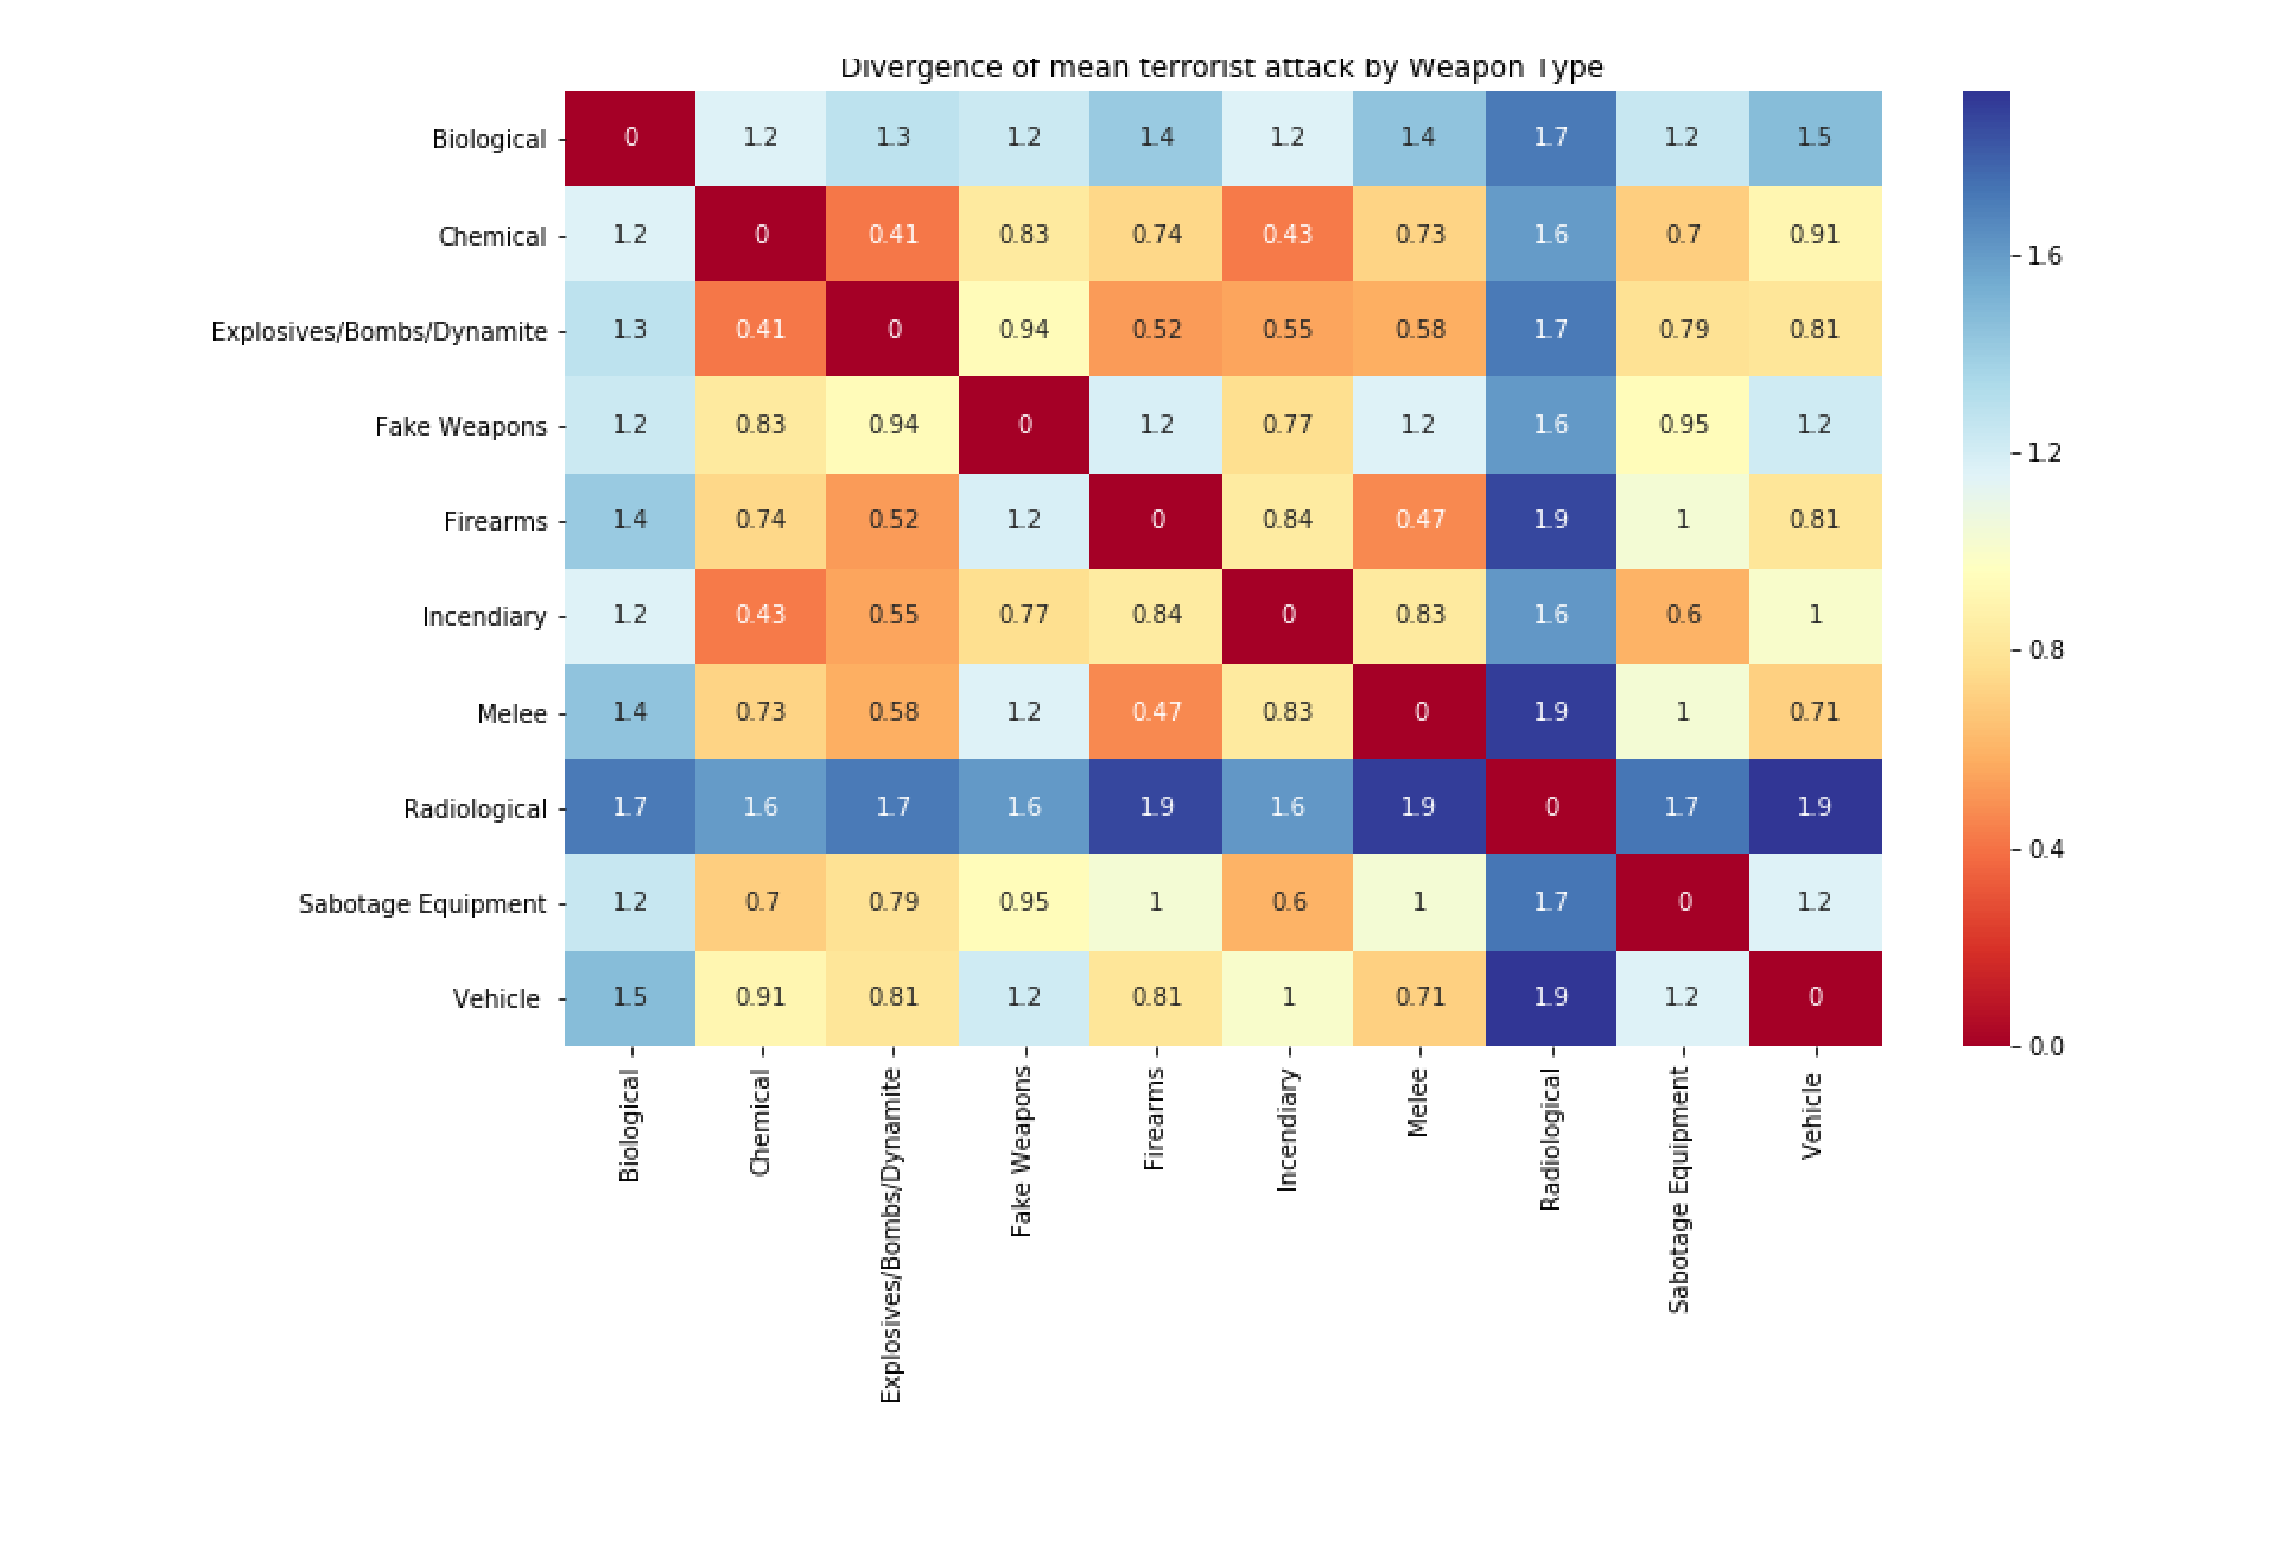

In [33]:
display_image('figures/all_weaptype_heatmap.png')

Above is an affinity map of terrorist attacks by weapon type. Evidently, some attack types are quite similar to one another, while others are relatively diffeerent. 

Like weapon types, target types display substantial variation. Notably, abortion-related attacks are substantially different from every other type of attack in the database.

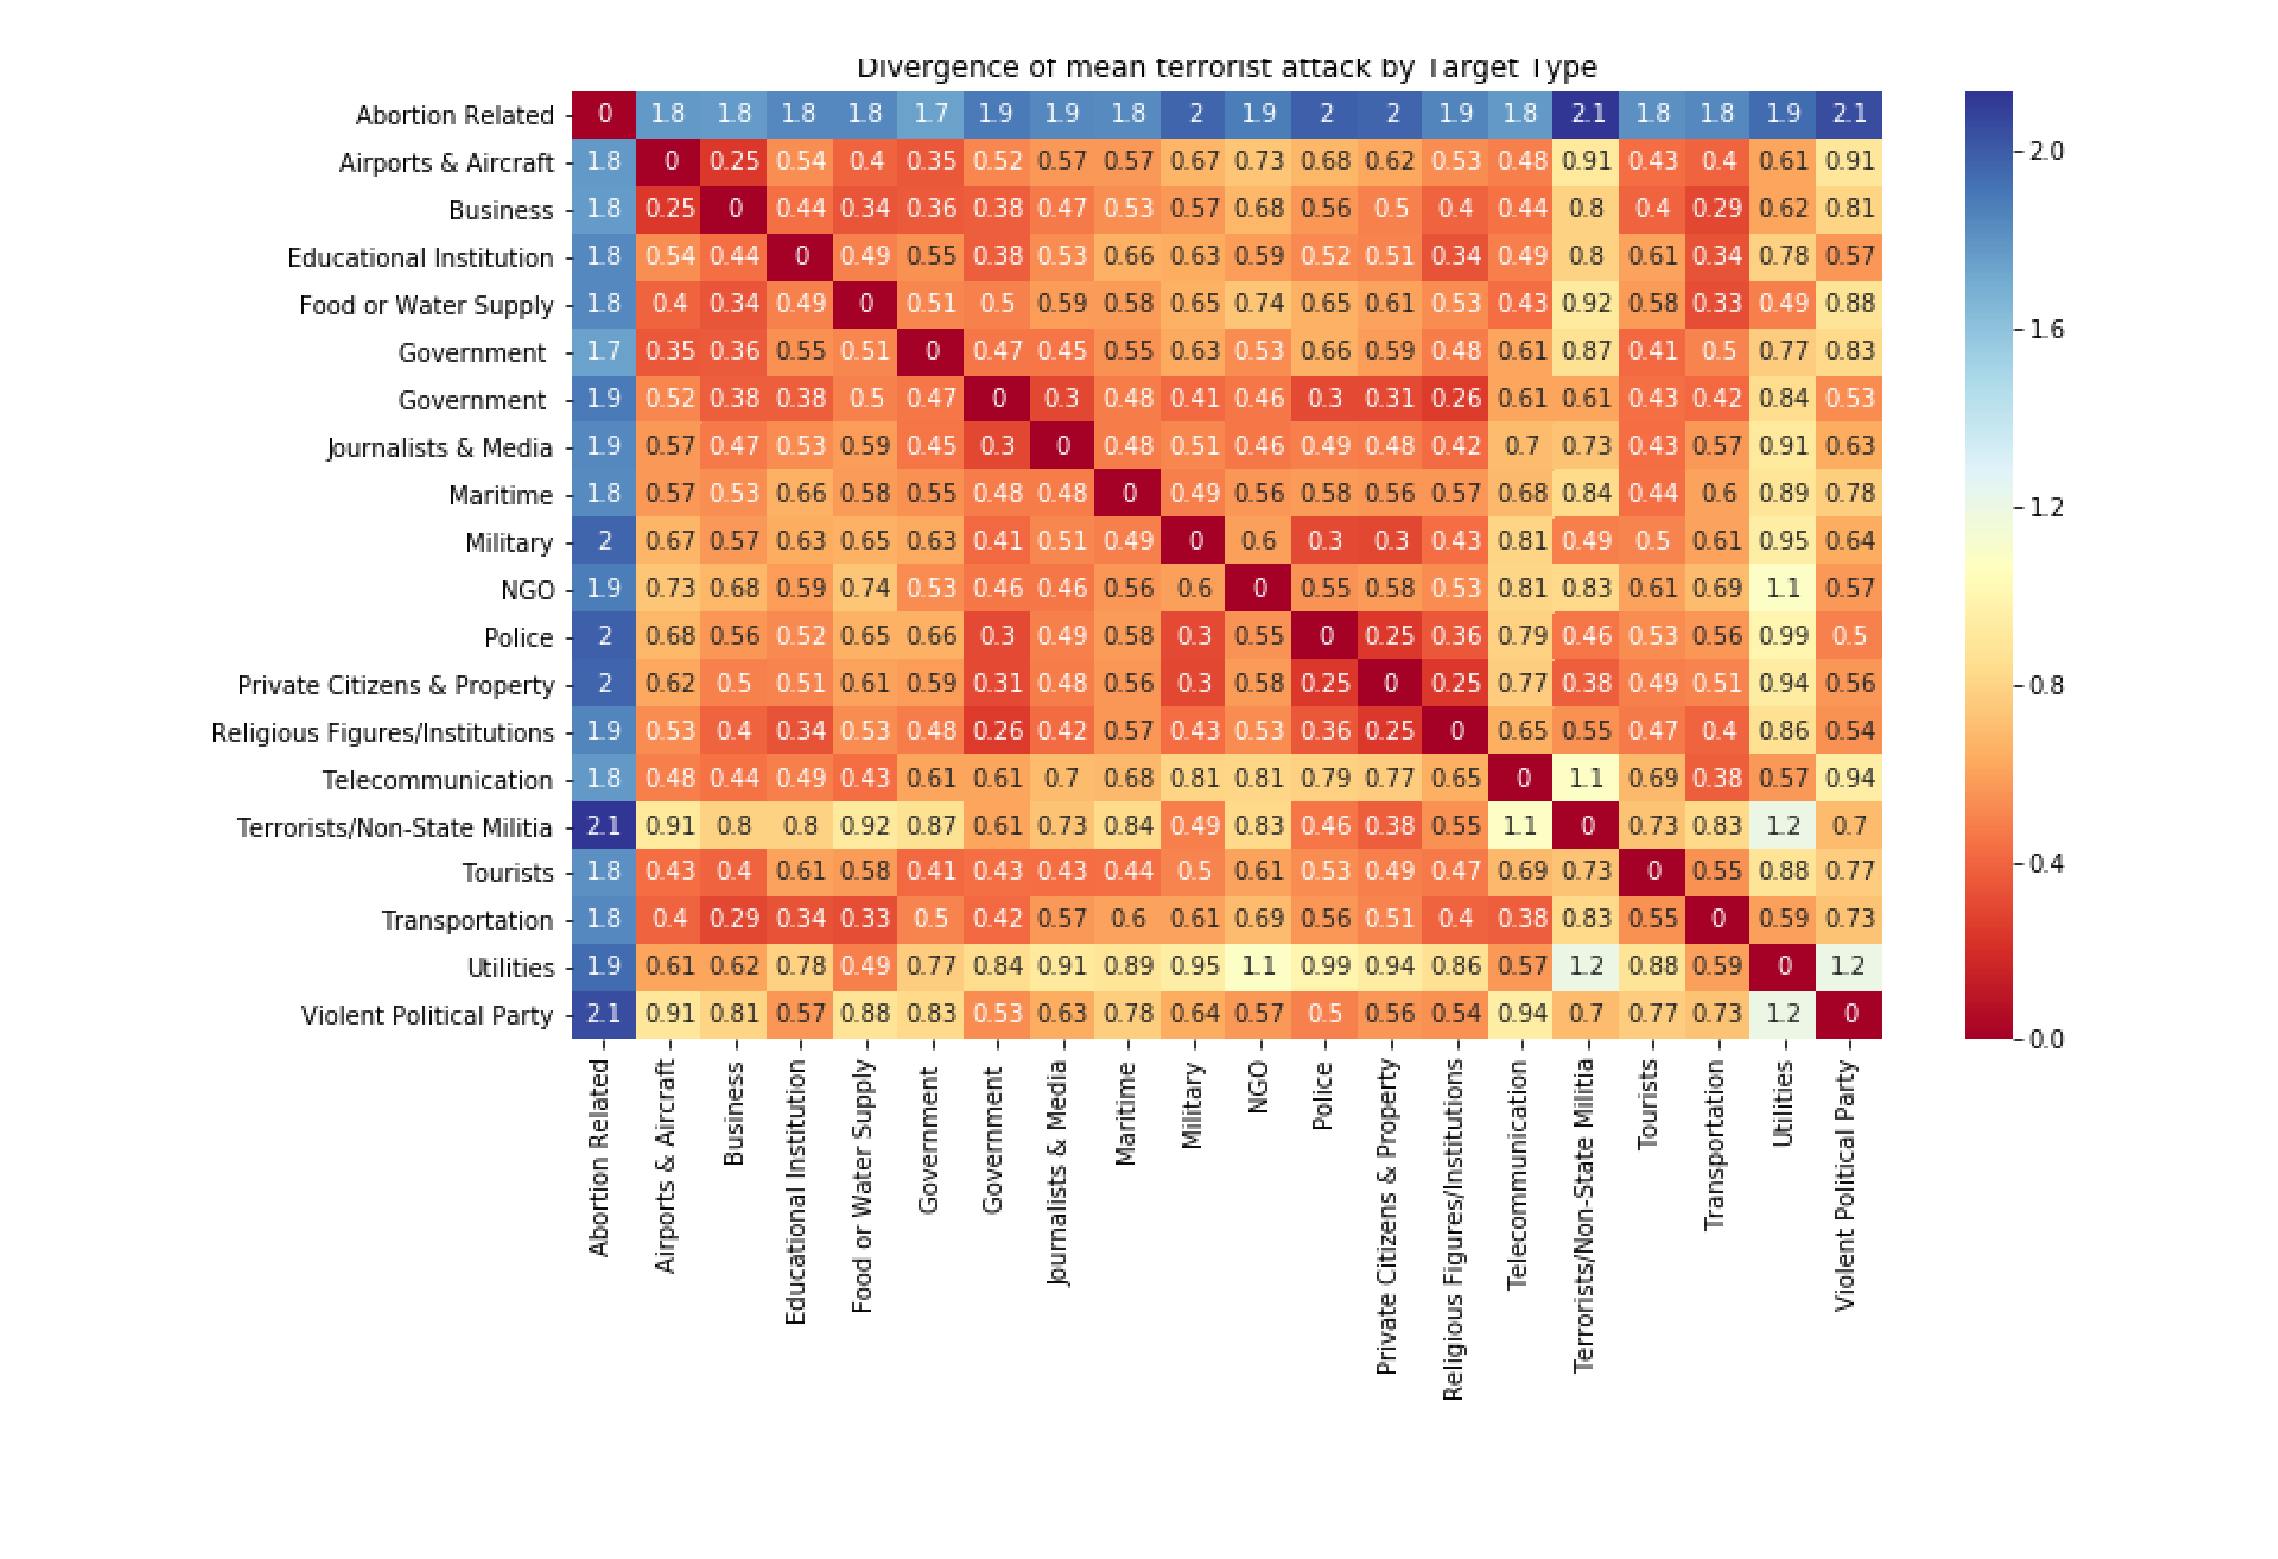

In [35]:
display_image('figures/all_targtype_heatmap.png')

For ease of interpretation, we display the affinity map above with only the 30% closest cells.

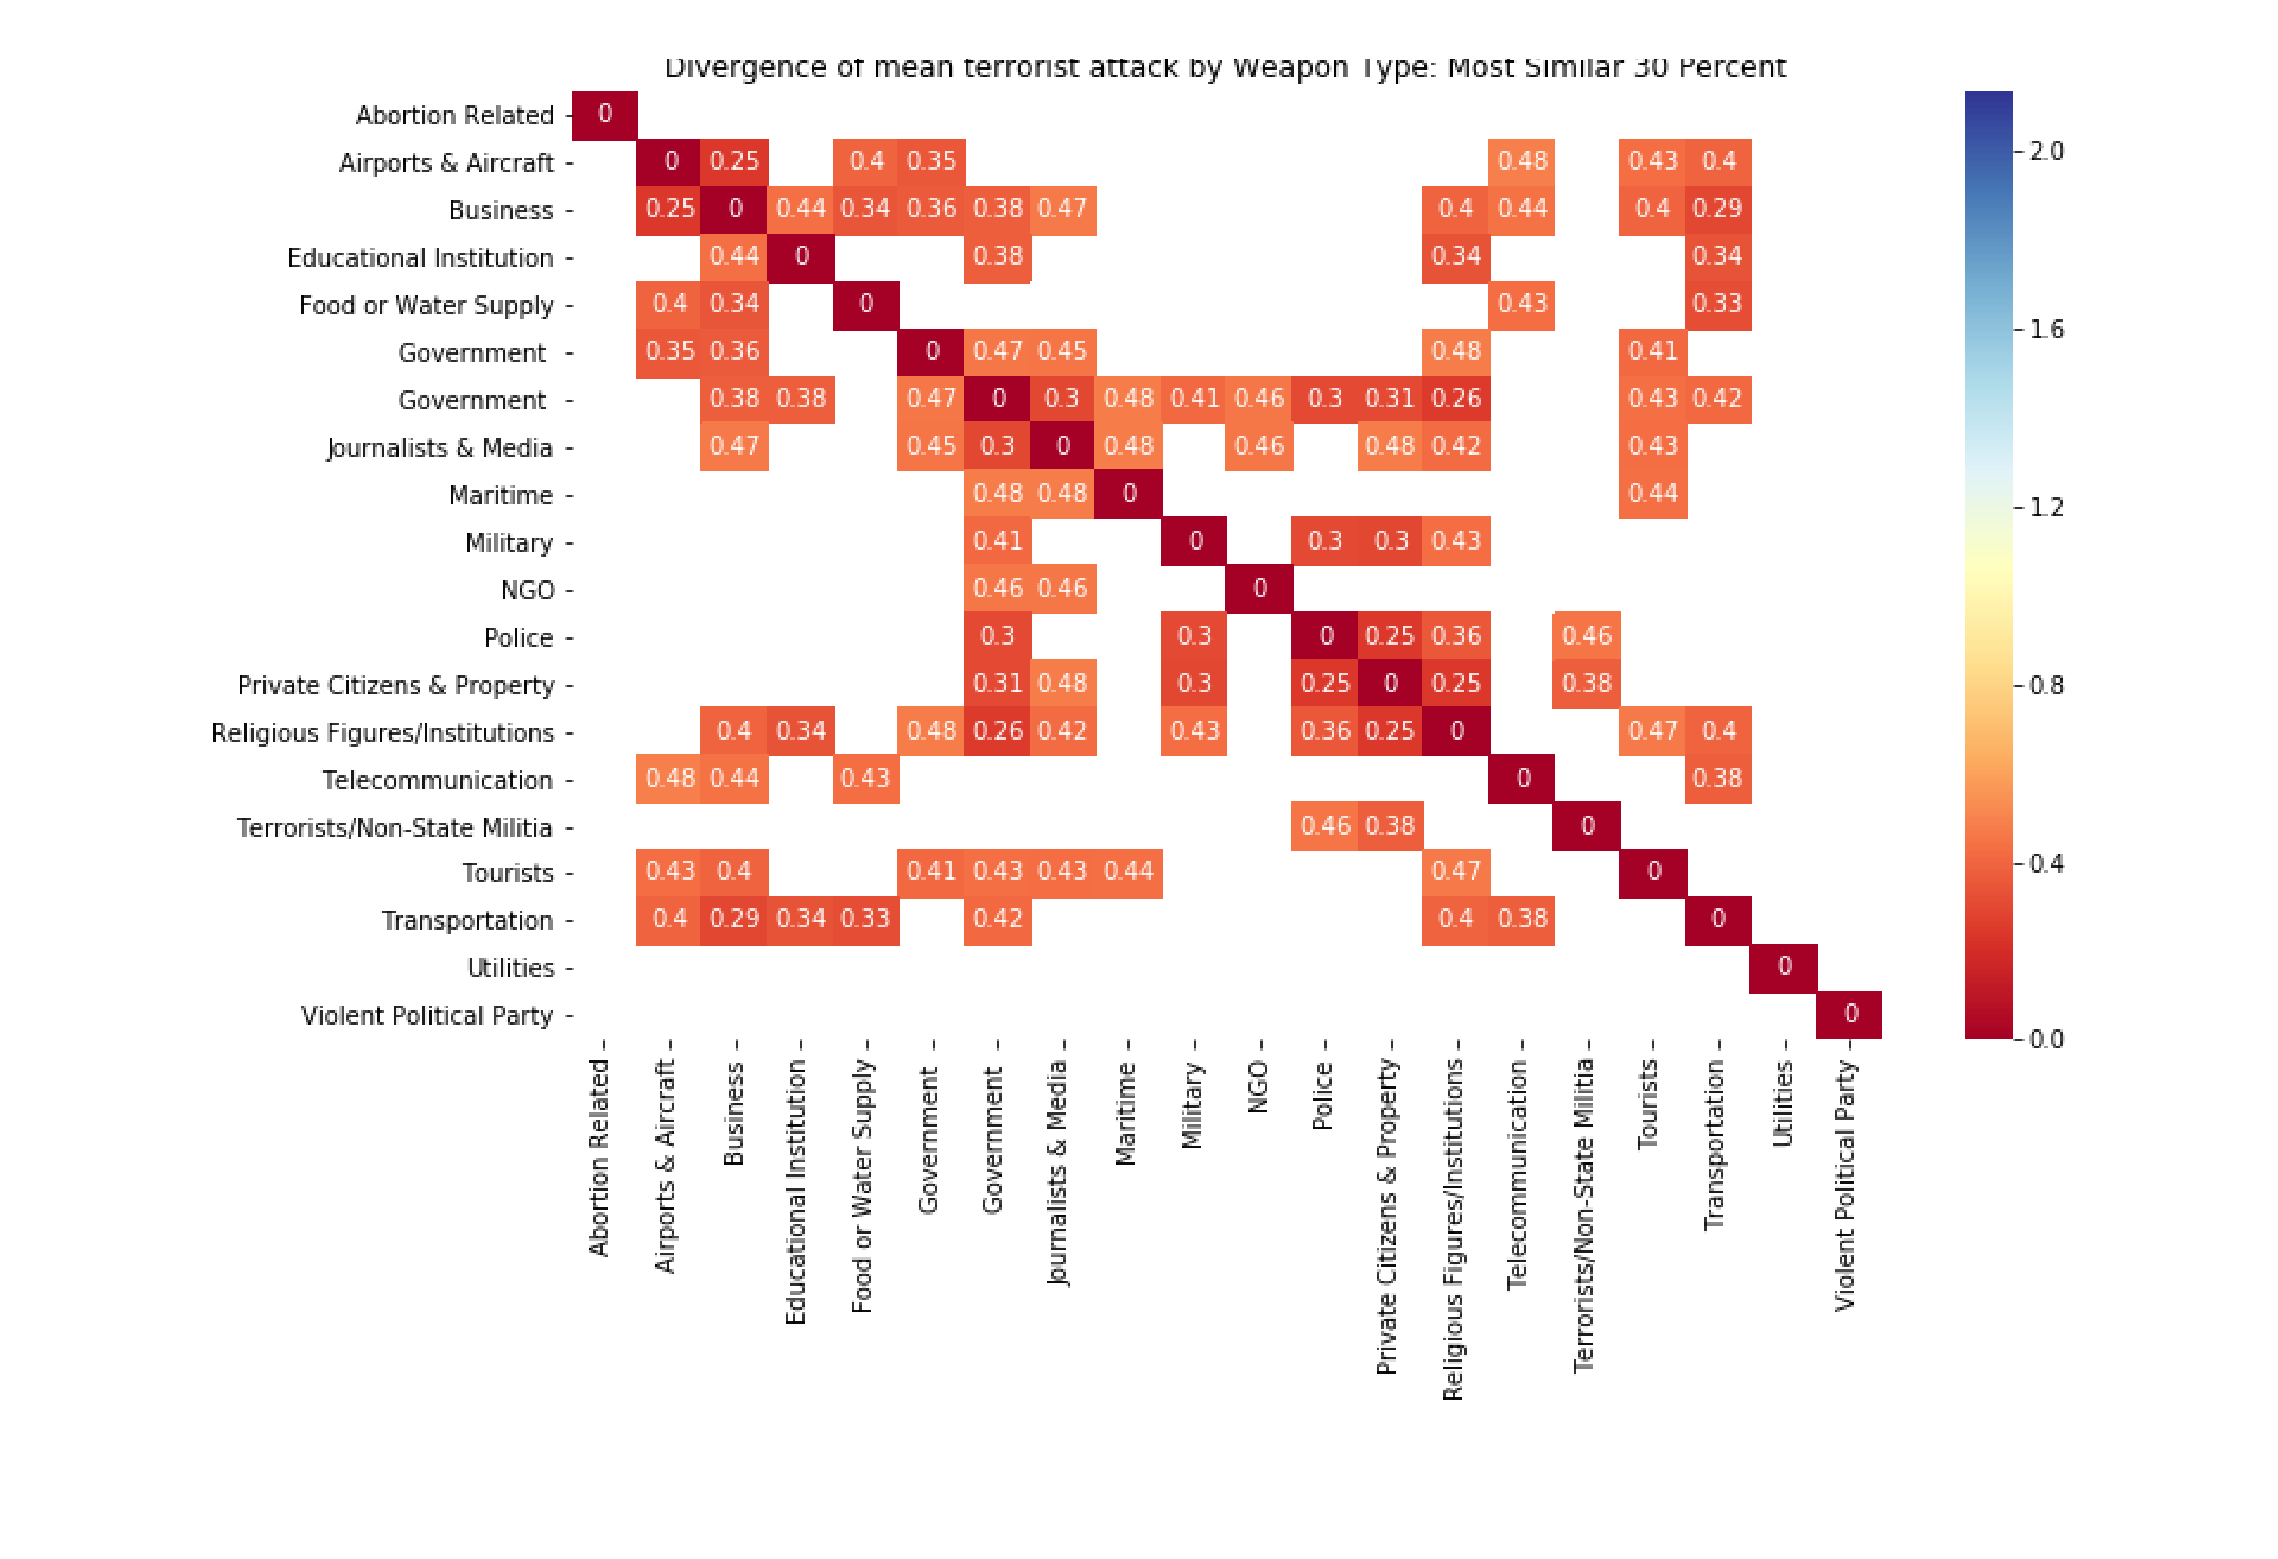

In [37]:
display_image('figures/top30_targtype_heatmap.png')

Finally, we display the affinity map of groups with over 500 recorded attacks in the database. With a few exceptions, most groups are not very similar to one another. 

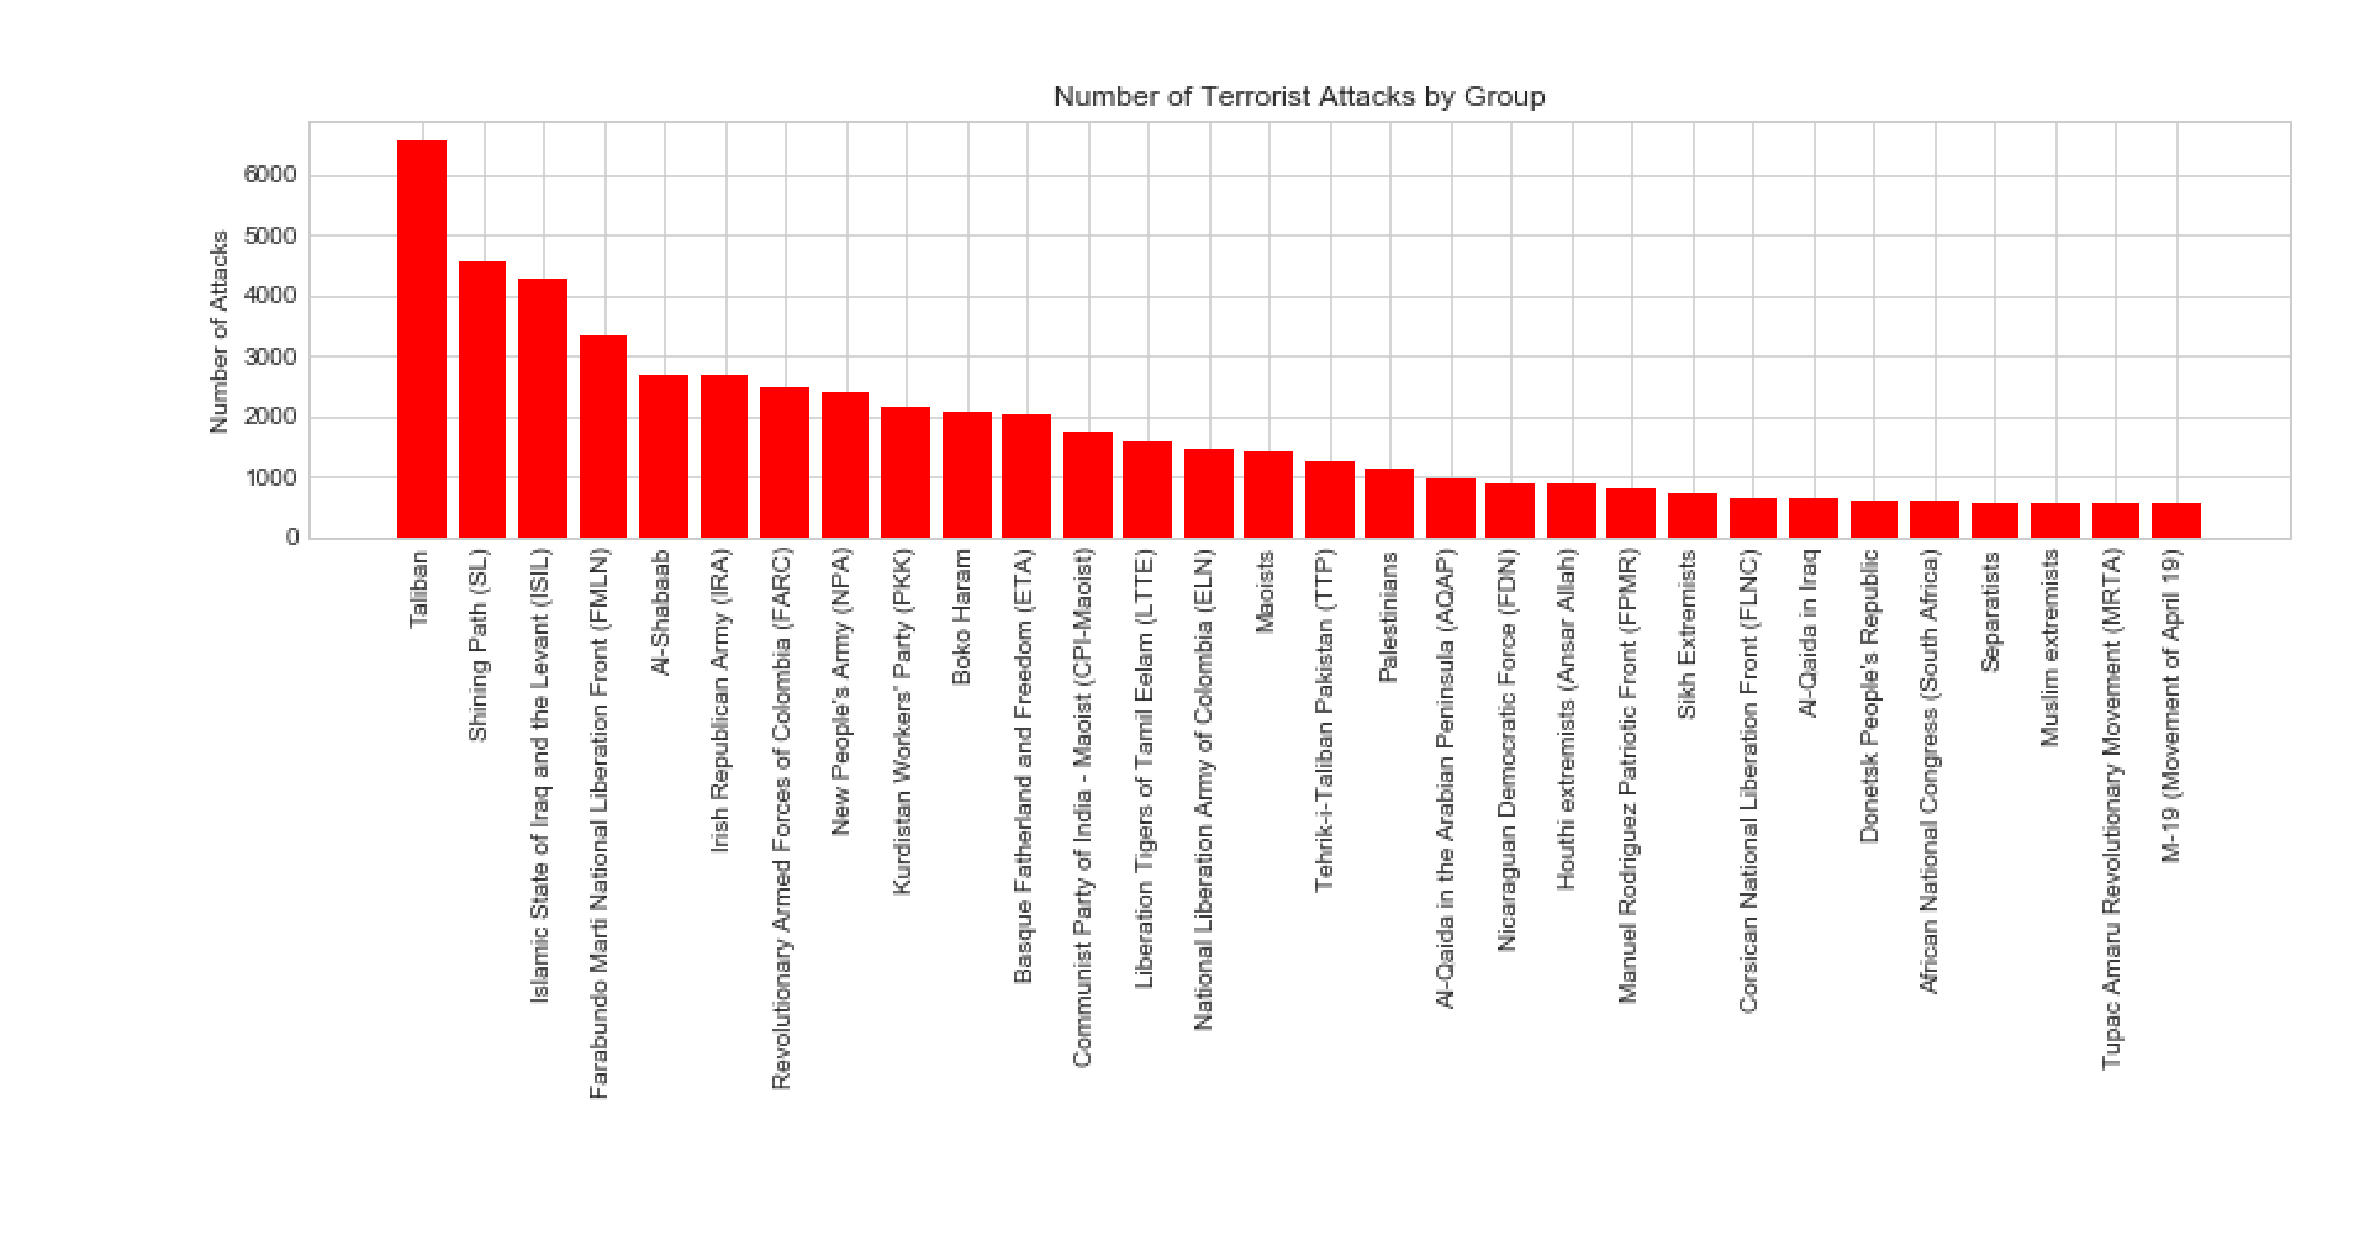

In [17]:
display_image('figures/top_groups_barplot.png')

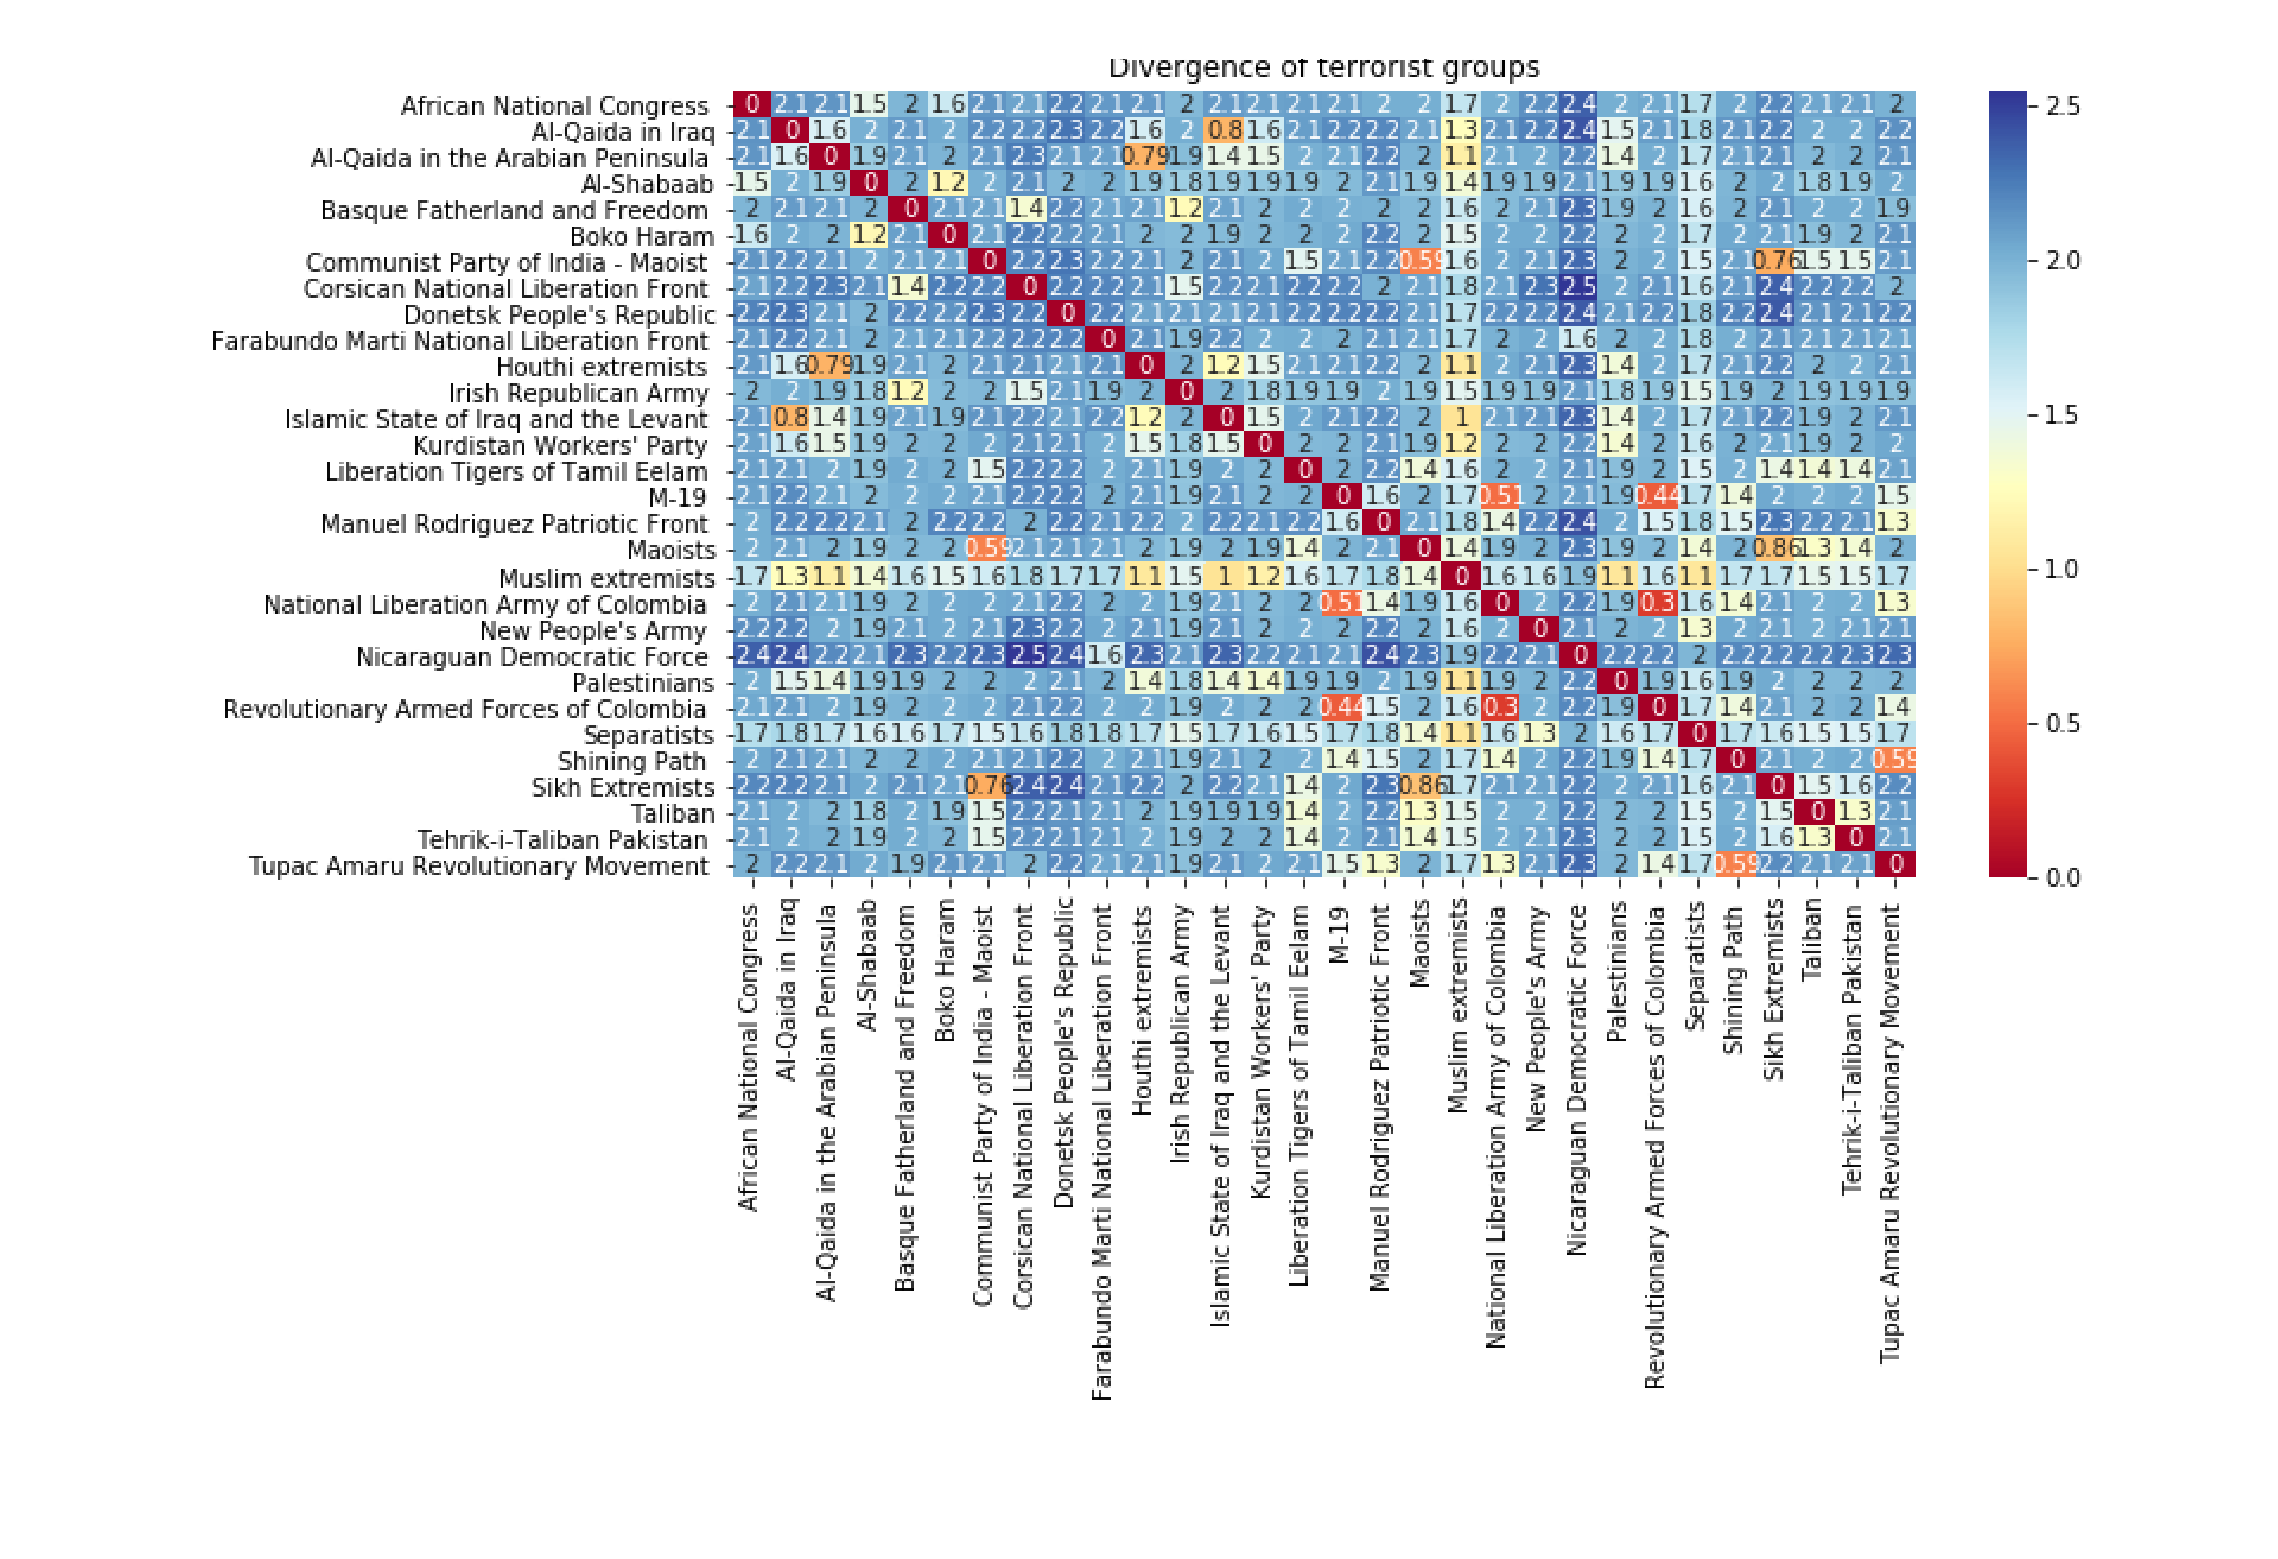

In [38]:
display_image('figures/all_groups_heatmap.png')

Here is the same figure, but with only the 30% of cells with the smallest distances.

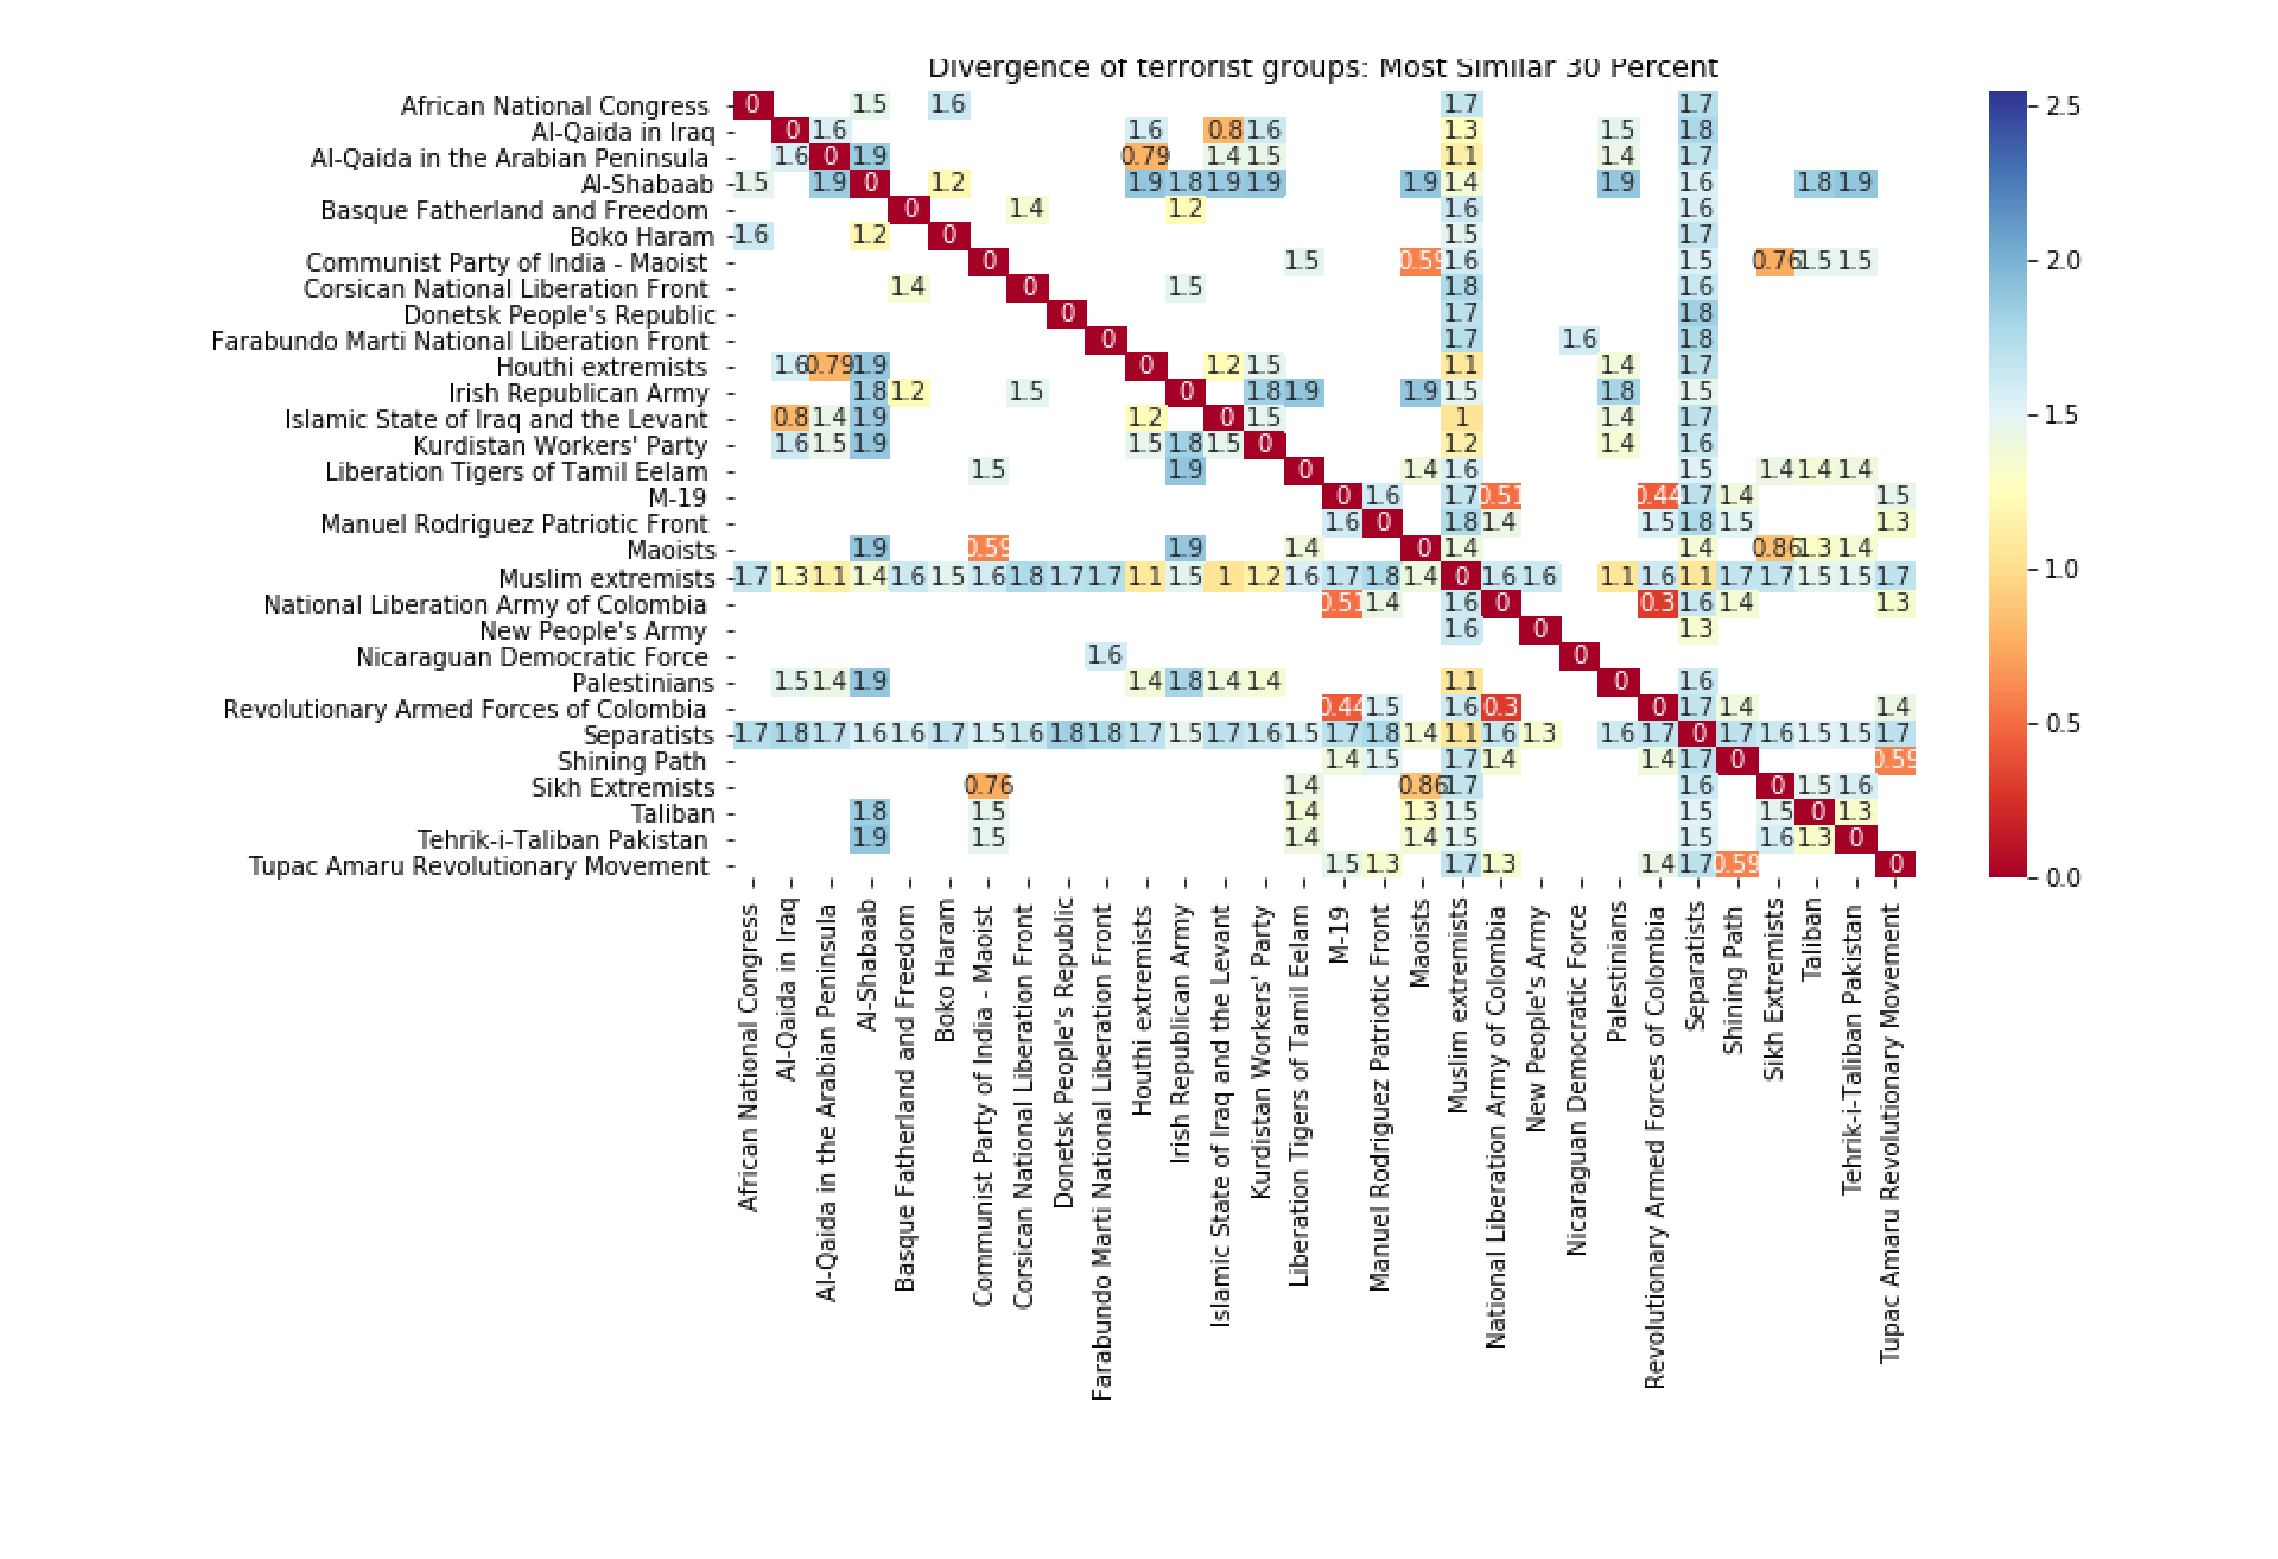

In [32]:
display_image('figures/top30_groups_heatmap.png')

Notably, there are strong similarities for groups based in the same country. FARC and M-19, both Colombian terrorist groups, have a very high level of similarity. So do Shining Path and Tupac Amaru Reviolutionary Movement, both from Peru. This indicates that country of origin is an important feature for future models.

# Prediction

Our database of attacks contained several success-related metrics for each attack, such as the number of people killed, number wounded, and number of Americans killed. We chose to concentrate on the categorical variable **success**, which for each attack was either 1 (true) or 0 (false). Whether an attack was deemed successful depended on the situational details, and was different for each type of attack. The database [codebook](http://www.start-dev.umd.edu/gtd/downloads/Codebook.pdf) explains that: 

> "Success of a terrorist strike is defined according to the tangible effects of the attack. Success is not judged in terms of the larger goals of the perpetrators. For example, a bomb that exploded in a building would be counted as a success even if it did not succeed in bringing the building down or inducing government repression.  
>The definition of a successful attack depends on the type of attack. Essentially, **the key question is whether or not the attack type took place.** If a case has multiple attack types, it is successful if any of the attack types are successful, with the exception of assassinations, which are only successful if the intended target is killed."

## Formalization 

Recall that in the pre-processing of the data, categorical information about each attack was converted to a vector representation using a one-hot encoding. For example, suppose that the variable "perpretator" has two possibilities: "Fernando" and "Eli." Then a one-hot encoding might represent "Fernando" as $\begin{bmatrix} 1 \\ 0\end{bmatrix}$ and "Eli" as $\begin{bmatrix} 0 \\ 1\end{bmatrix}$. 

Given an attack with several categorical variables, its vectorized representation is thus a vector $\vec{v} \in \mathbb{R}^{n}$ which is really a "stack" of smaller one-hot vectors corresponding to each feature. If we use $m$ categorial features from each attack, each vector $\vec{v}$ will have precisely $m$ entries whose value is $1$, and all others $0$. 

Not all of the features were categorical. Numerical features, such as "number of people killed" or "year" might have been converted into a one-hot encoding, or simply appended to the one-hot vector. See the analysis notebooks for more detail. 

Suppose then that we have $n$ vectors $\vec{x_{1}}, ..., \vec{x_{n}}$, each corresponding to an attack. Each attack vector $\vec{x_i}$ has a label $y_{i} \in \{0, 1 \}$ which is $1$ if the attack was successful, and $0$ if the attack was unsuccessful. 

Given vectorized data and class labels, we can split the data into a training and test set and perform cross-validation. The goal of any model is to learn a model from the training data, and then predict (with as high a degree of accuracy as possible) the labels of the test data.

## LASSO Regression

LASSO regression, or Least Absolute Shrinkage and Selection Operator, is a linear regression model which is suitable for sparse datasets. The goal of LASSO is to learn a set of weights corresponding to each entry of an input vector. When given an input, it uses these weights to compute a linear combination, which is the output. 

As above, suppose we have $n$ vectors $\vec{x_{1}}, ..., \vec{x_{n}}$, each corresponding to an attack. Each attack vector $\vec{x_i}$ has a label $y_{i} \in \{0, 1 \}$ which is $1$ if the attack was successful, and $0$ if the attack was unsuccessful. We can "matricize" these data by "stacking up" the $\vec{x_{1}}, ..., \vec{x_{n}}$ into a matrix $X\in \mathbb{R}^{n \times d}$, where each row of $X$ is a different data point. Similarly, we stack up the labels $y_{i}$ into a label vector $y \in \mathbb{R}^{n}$. 

LASSO regression will choose the weight vector $w^{*} \in \mathbb{R}^{d}$ such that 

$$w^{*} = \arg\min_{w \in \mathbb{R}^{d}} \frac{1}{2n}\| Xw - y \|^{2} + \alpha \| w \|_{1}$$

The term $\alpha \| w \|_{1}$ in the objective function is a penalty term for large $w$. Penalizing $w$ with the $\ell_{1}$ norm, as opposed to the $\ell_{2}$ norm used in ridge regression, encourages a sparse solution. This is appropriate given the one-hot encoding of our data, as each input vector will only have a few nonzero entries. 

A benefit of the LASSO model (indeed, any linear regression model) is its **interpretability**. By examining the entries of $w^{*}$ we can understand what features the model considers more or less important in predicting the success of an attack.

### Hyperparamter Optimization

The value $\alpha$ in LASSO is determined before training the model, and is thus a *hyperparameter*. We performed grid search across 50 different $\alpha$ (log-spaced on $[10^{-6}, 10^{-2}]$) in order to determine the best $\alpha$. 

For details, see the notebook ```counter_terrorism_lasso```.

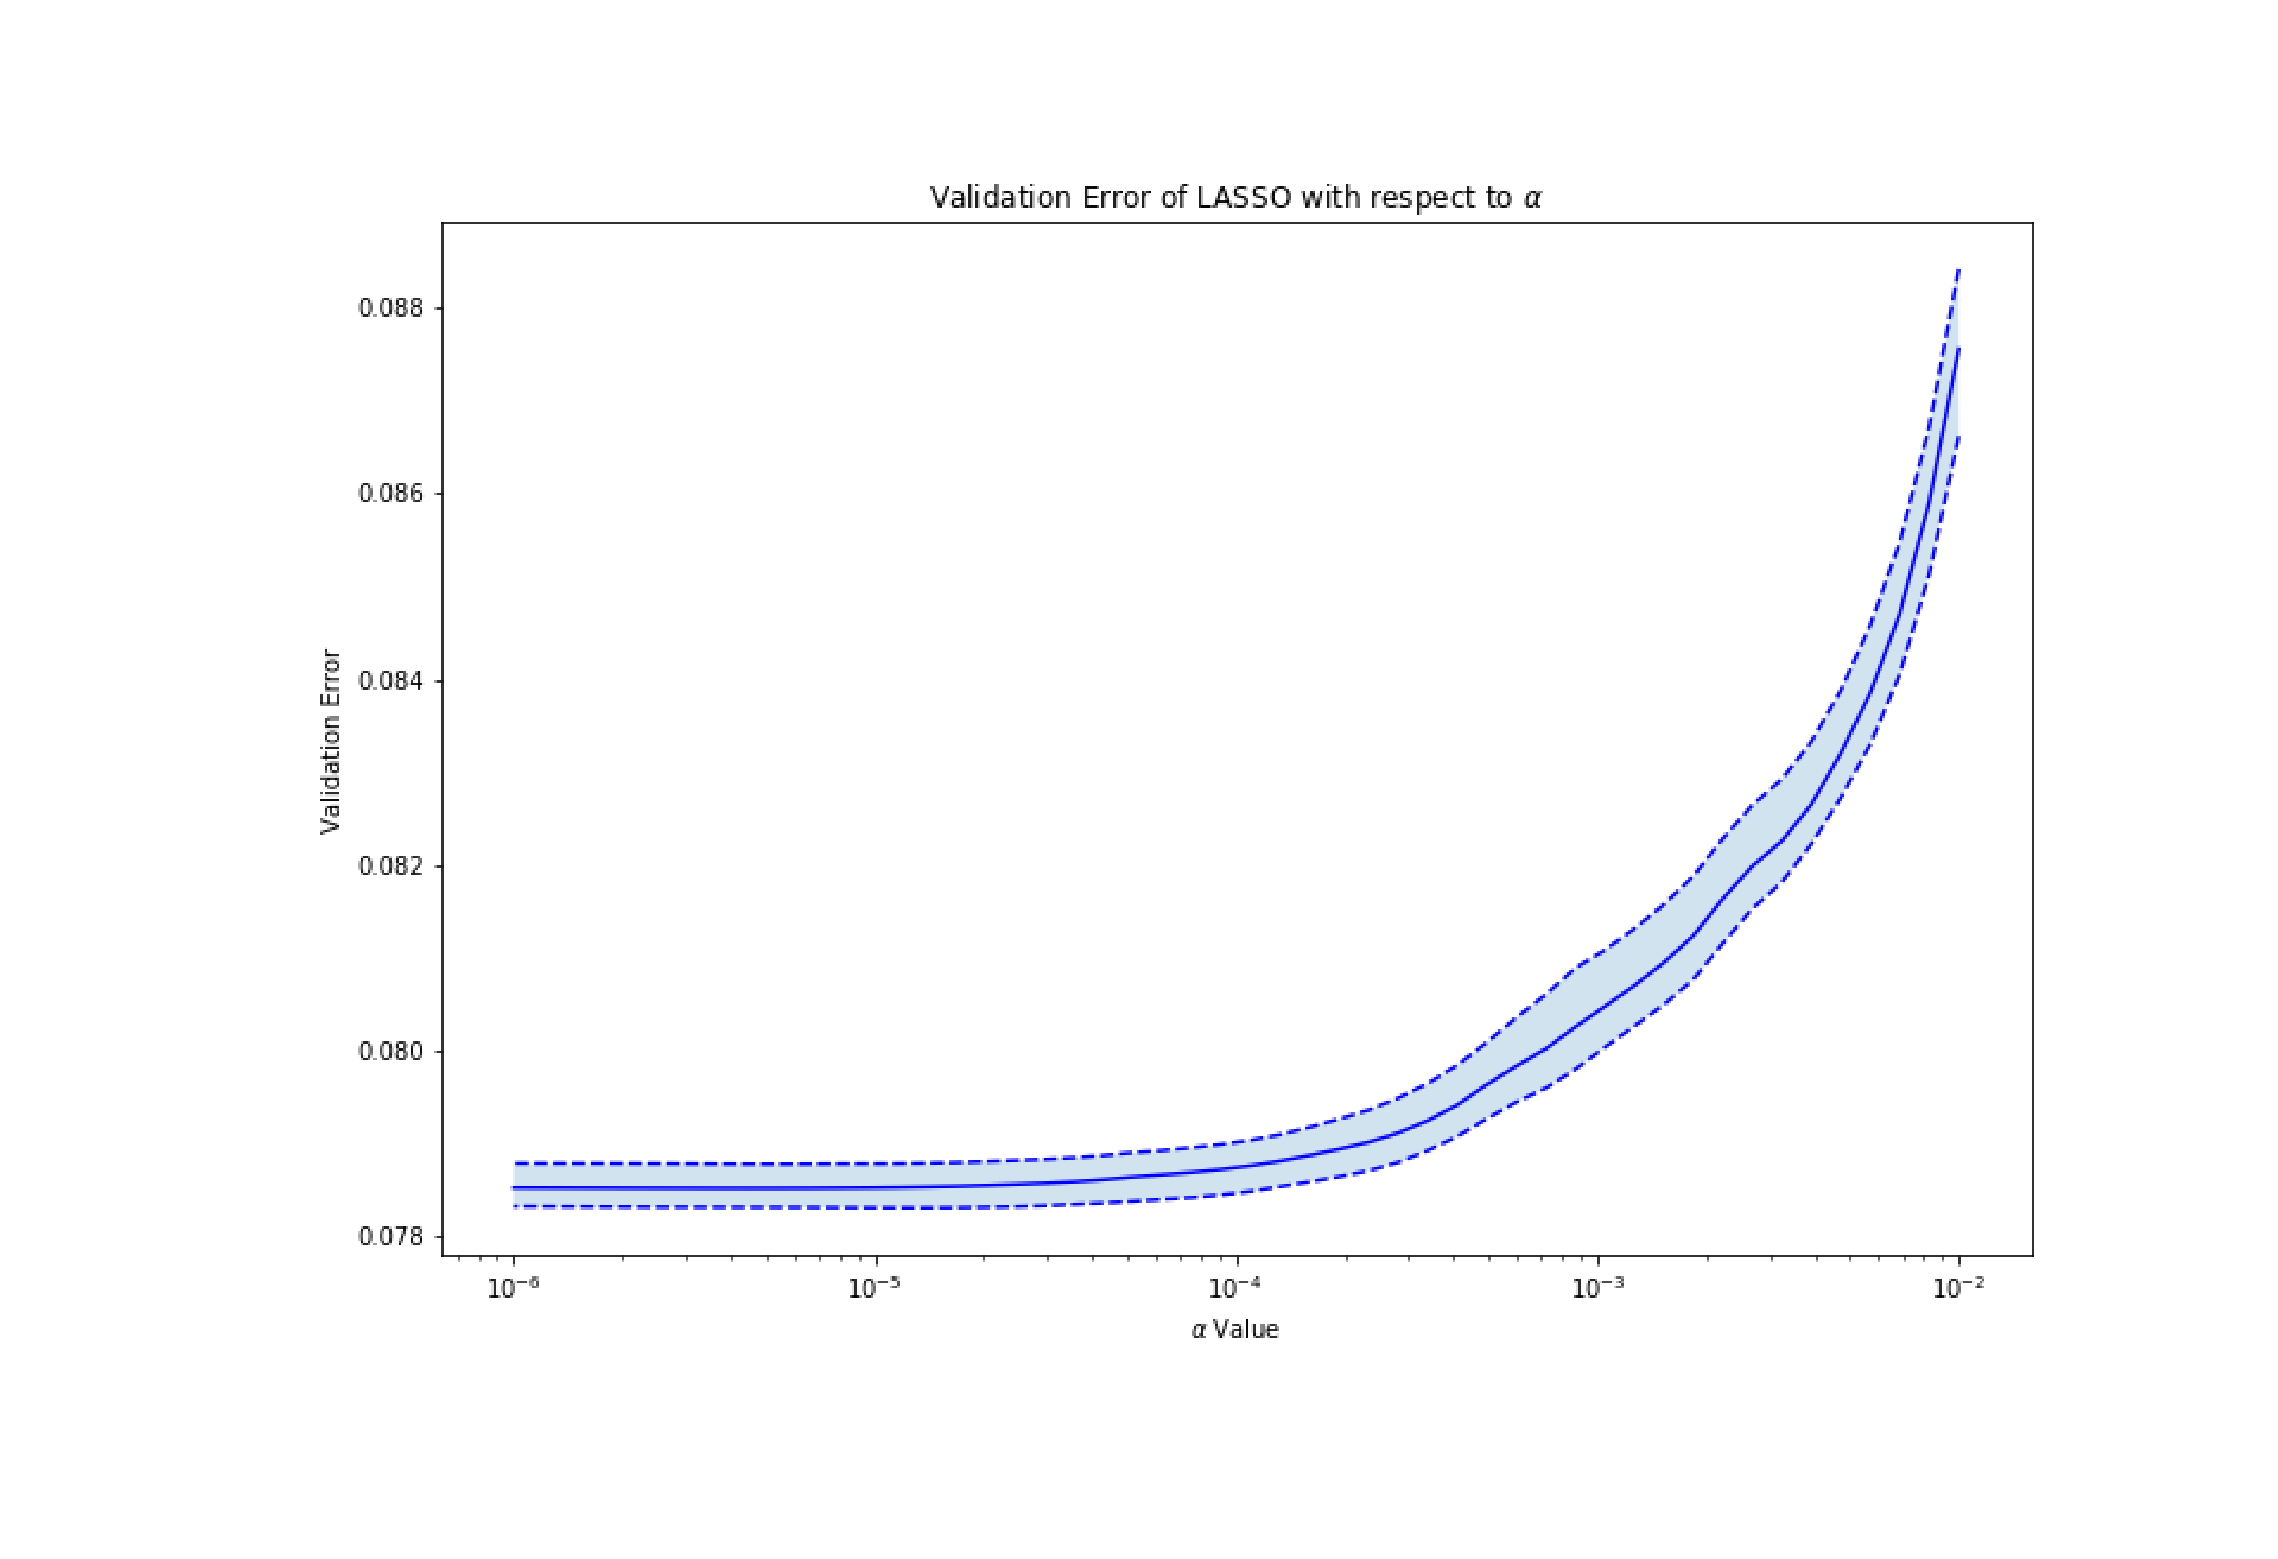

In [4]:
display_image('figures/lasso_cv_alphas_error.png')

### Results

The overall binary accuracy of the Lasso model on validation data was 0.85

We also evaluate model performance using ROC Curves. For information on ROC Curves, see ```counter_terrorism_neural_nets```. 

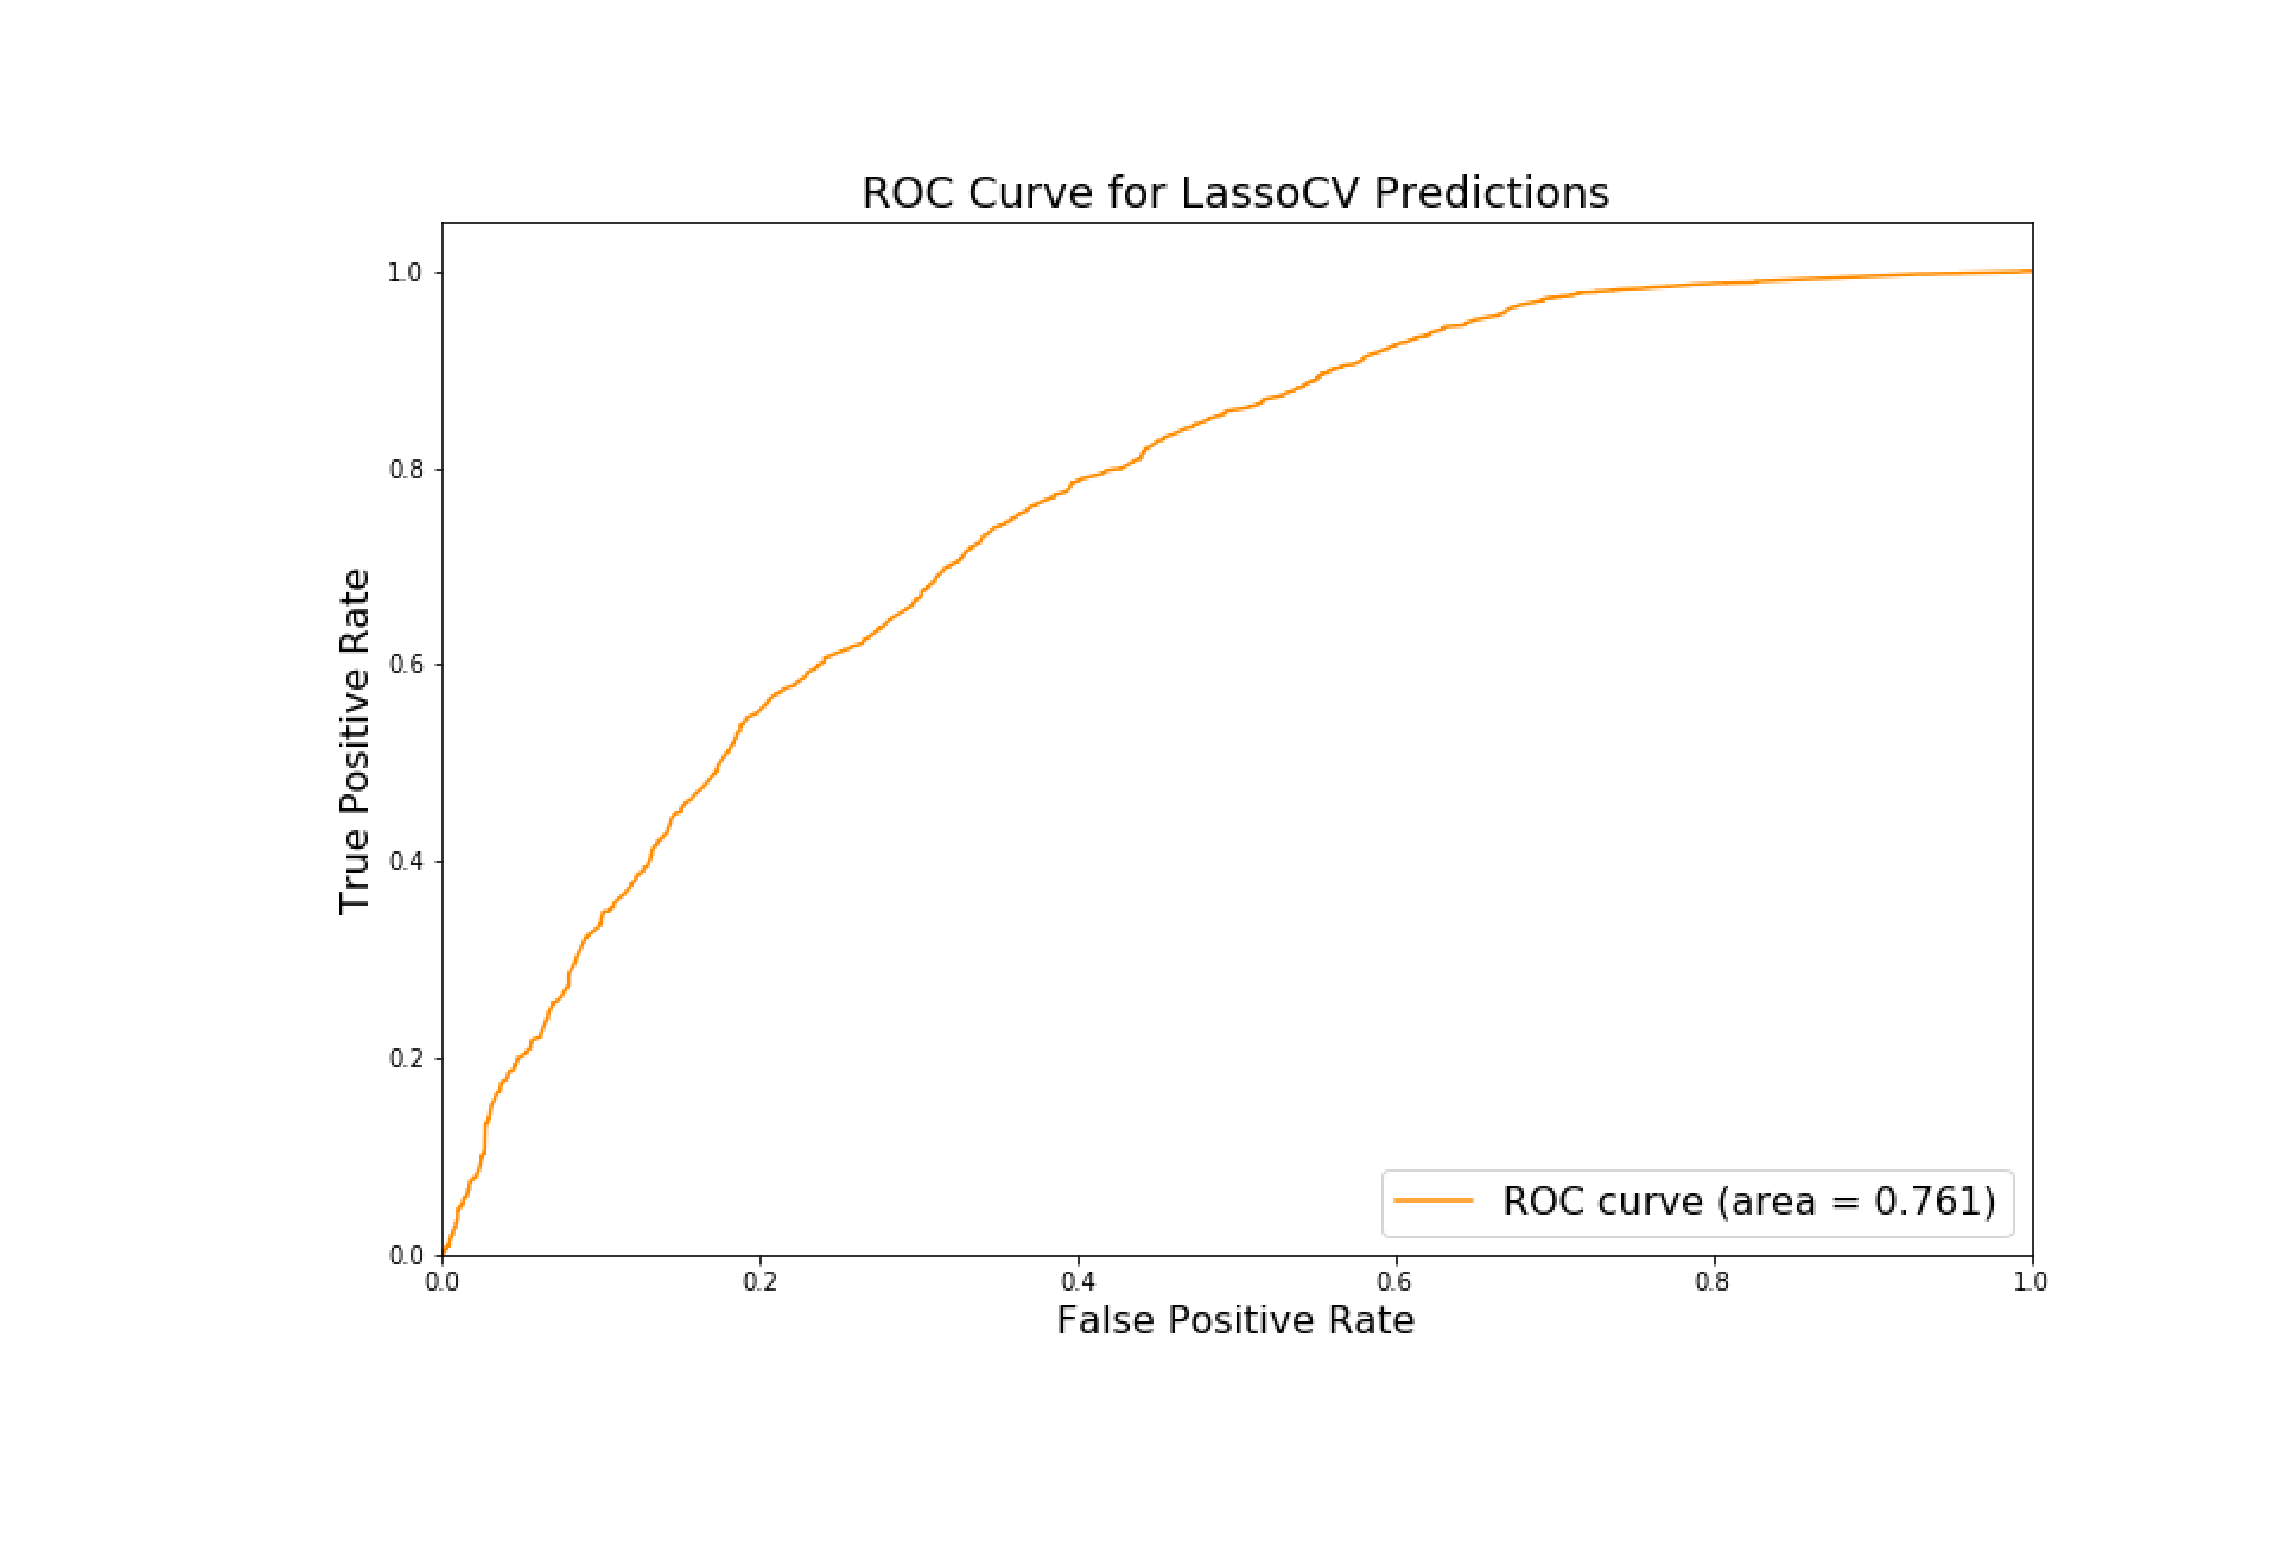

In [4]:
display_image('figures/lassoROC.png')

We can also see which features most strongly influence the success probability of a terrorist attack by looking at the weights of the lasso models. 

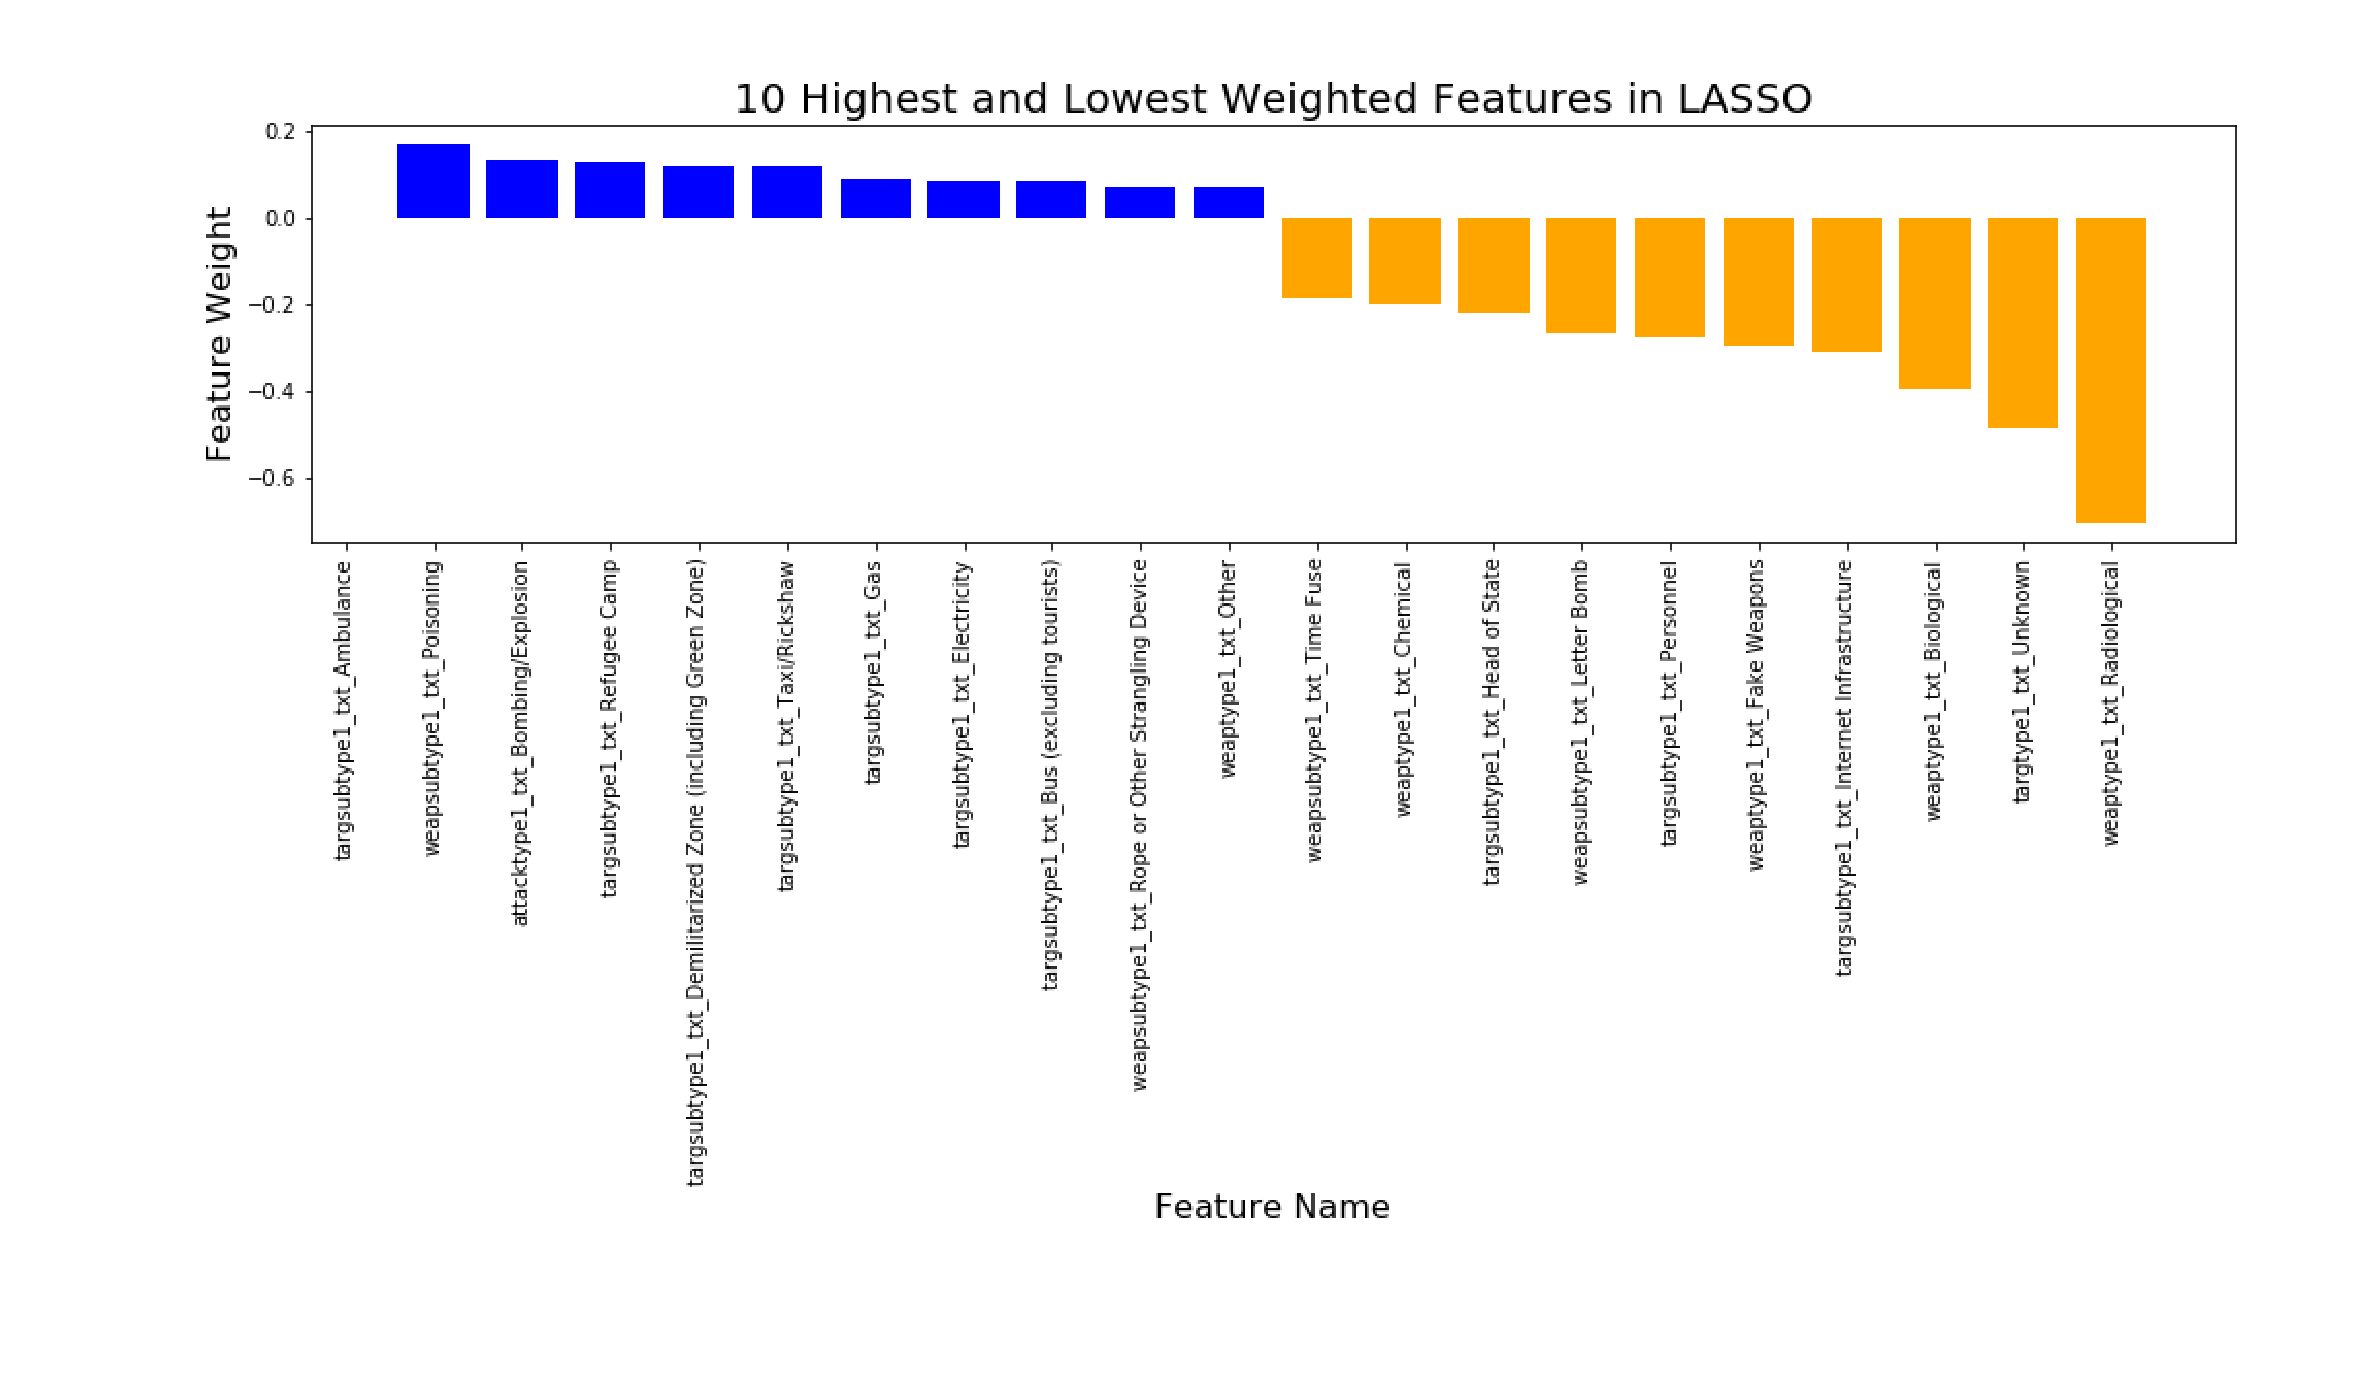

In [7]:
display_image('figures/lasso_cv_feature_weights.png')

From this, it appears that ambulances and refugee camps are the most vulnerable to attack and that poisonings and bombings are the most likely type of terrorist attack to succeed.

## Neural Network

Although they are not very interpretable, Neural Networks have the capability to fit more complex decision functions and therefore tend to have the strongest predictive power when provided enough data. 

### Benefits

1. **Universal Approximation**: The generally high predictive power of Neural Networks can in part be explained by the Universal Approximation Theorem, which states that a multilayer perceptron is able to approximate continuous functions on compact subsets of $R^{n}$. 


2. **Binary Classification**: By employing a binary cross-entropy loss function, neural networks are well-suited to approach binary classification problems. In combination with the Universal Approximation Theorem, this means that a neural network can approximate any decision function in $R^{n}$, the space of independent variables. 

### Hyperparameter Optimization

Due to the large number of hyperparameters, grid search is impossible. Instead, we will run a hyperparameter search by first trying out different activation functions, then model architectures.

Since the data is on the scale of hundreds of thousands of rows, it is highly likely that a neural network will do better than a linear model. 

First testing the activation functions yield, we see the following validation accuracies over successive training epochs:

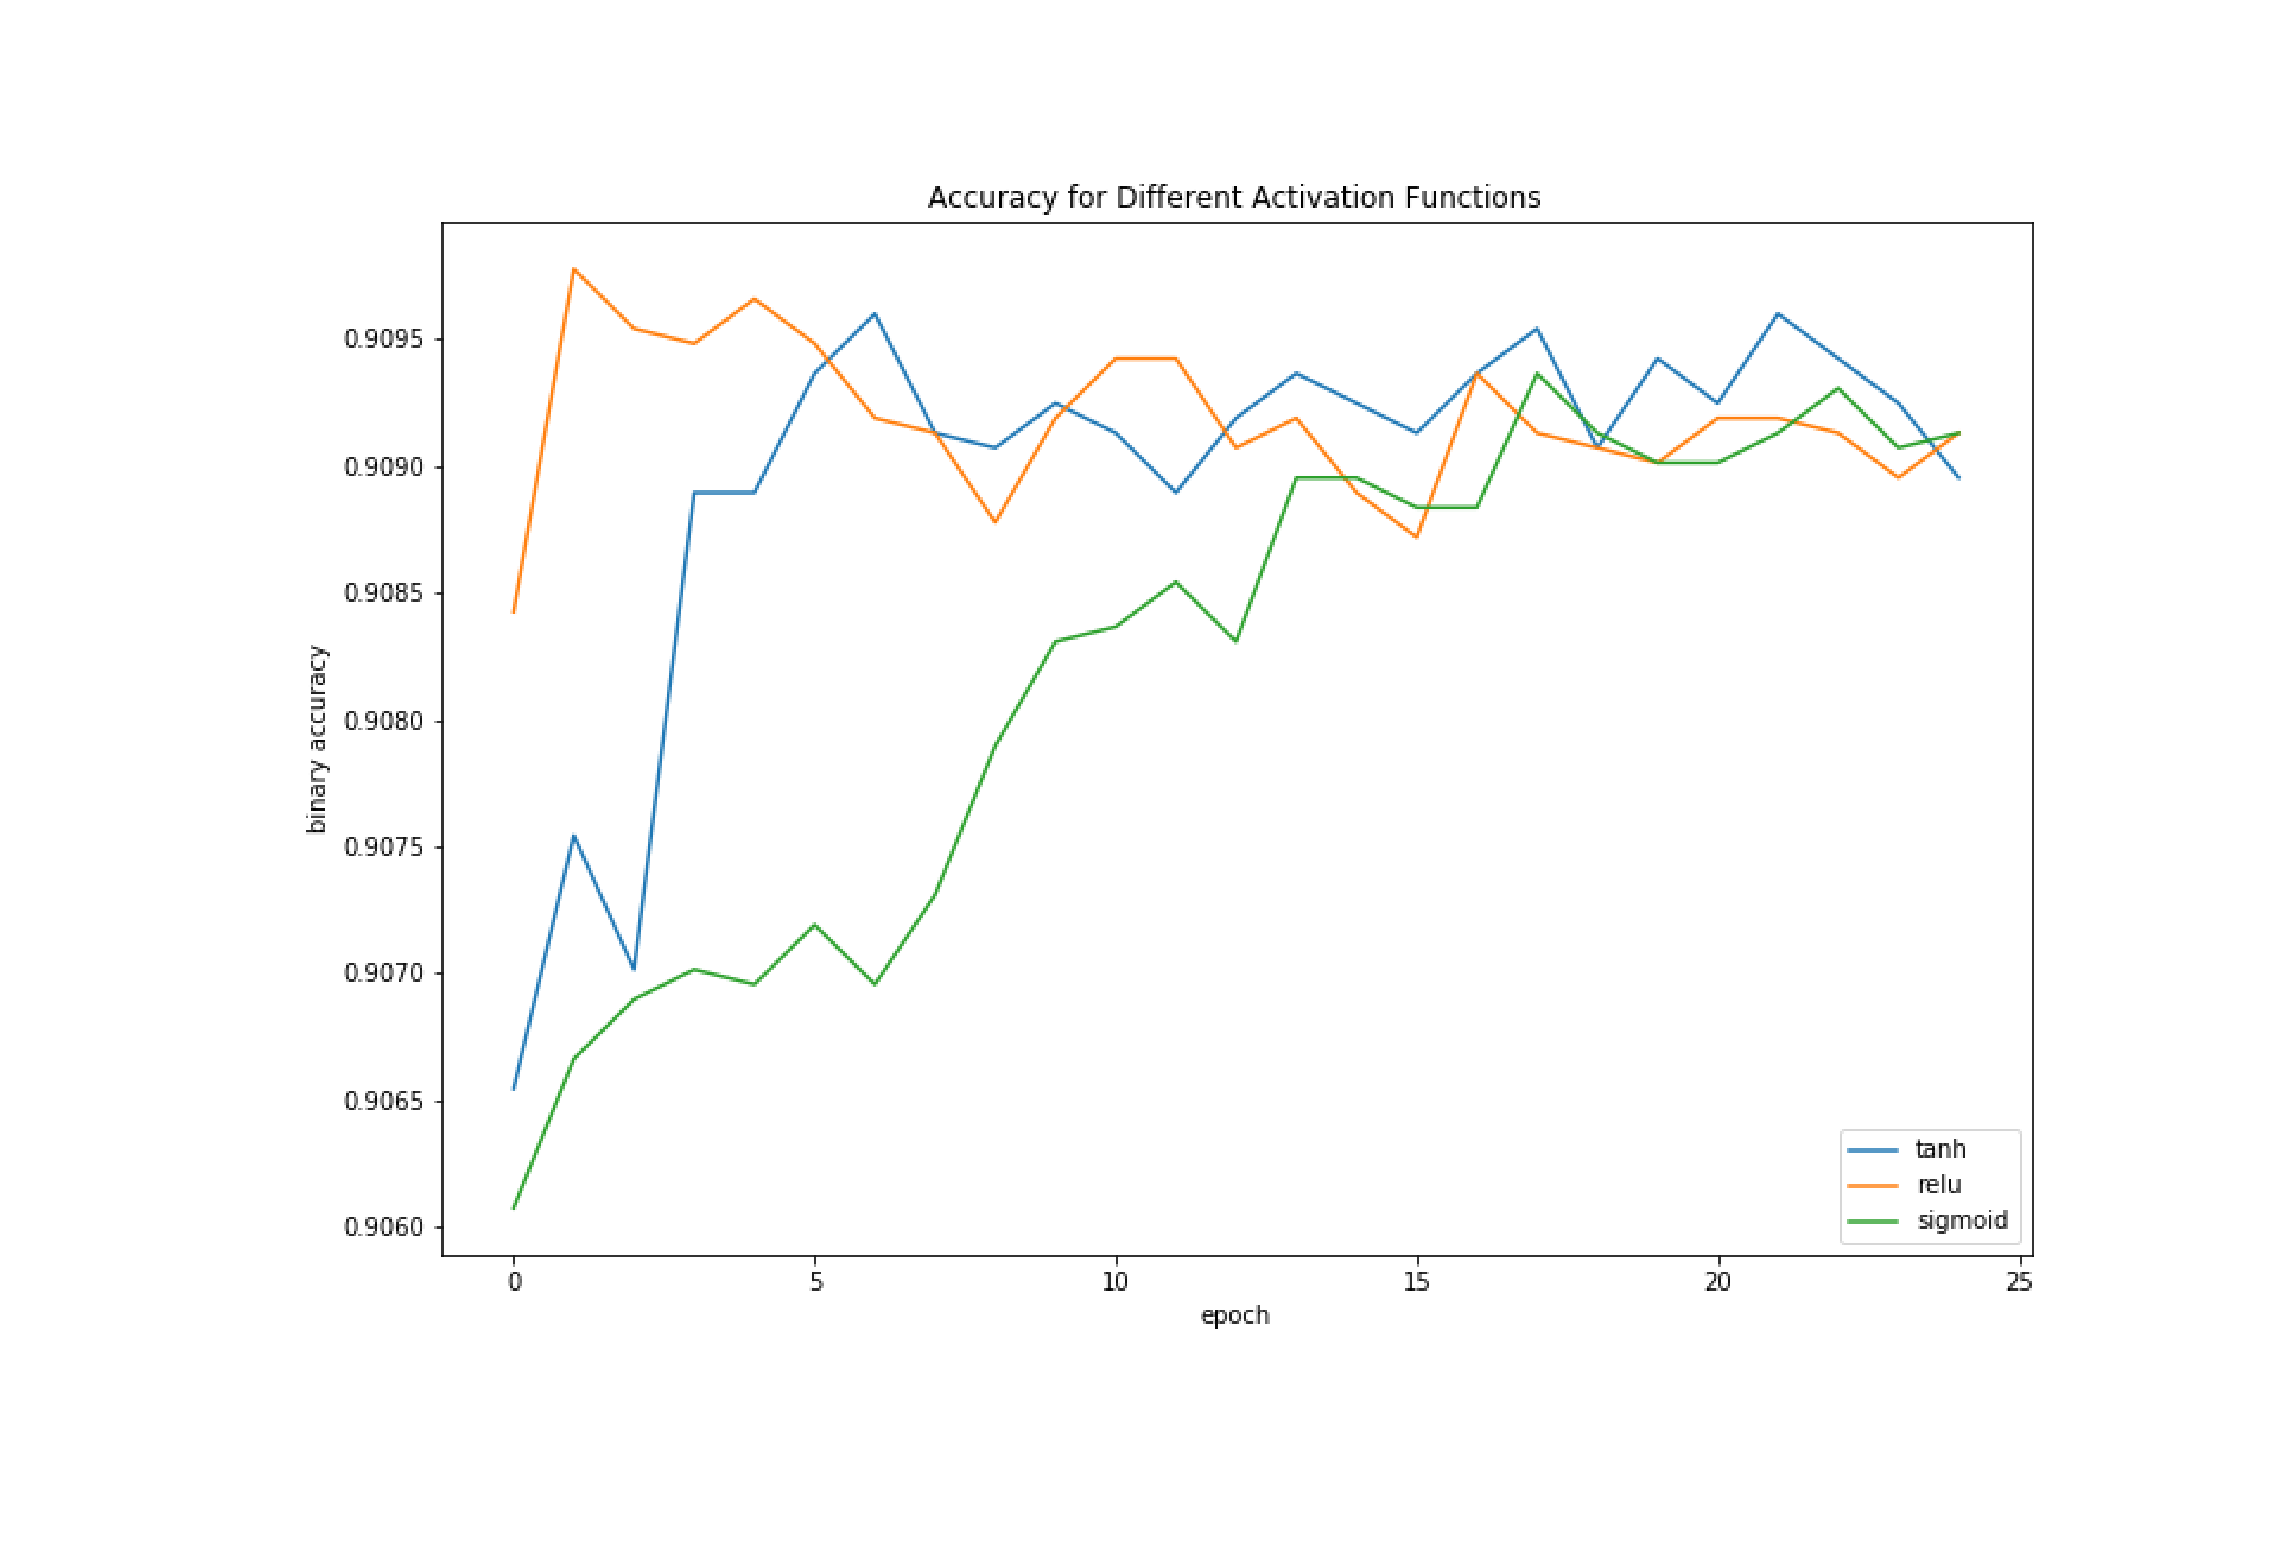

In [9]:
display_image('figures/neural_net_activations.png')

Since tanh activations had the most consistent validation accuracy, we use this for testing different model architectures.

We test the following architectures:
- Wide: 2 layers, 32 hidden nodes per layer
- Wider: 2 layers, 64 hidden nodes per layer
- Deep: 3 layers, 10 hidden nodes per layer
- Big: 3 layers, 32 hidden nodes per layer

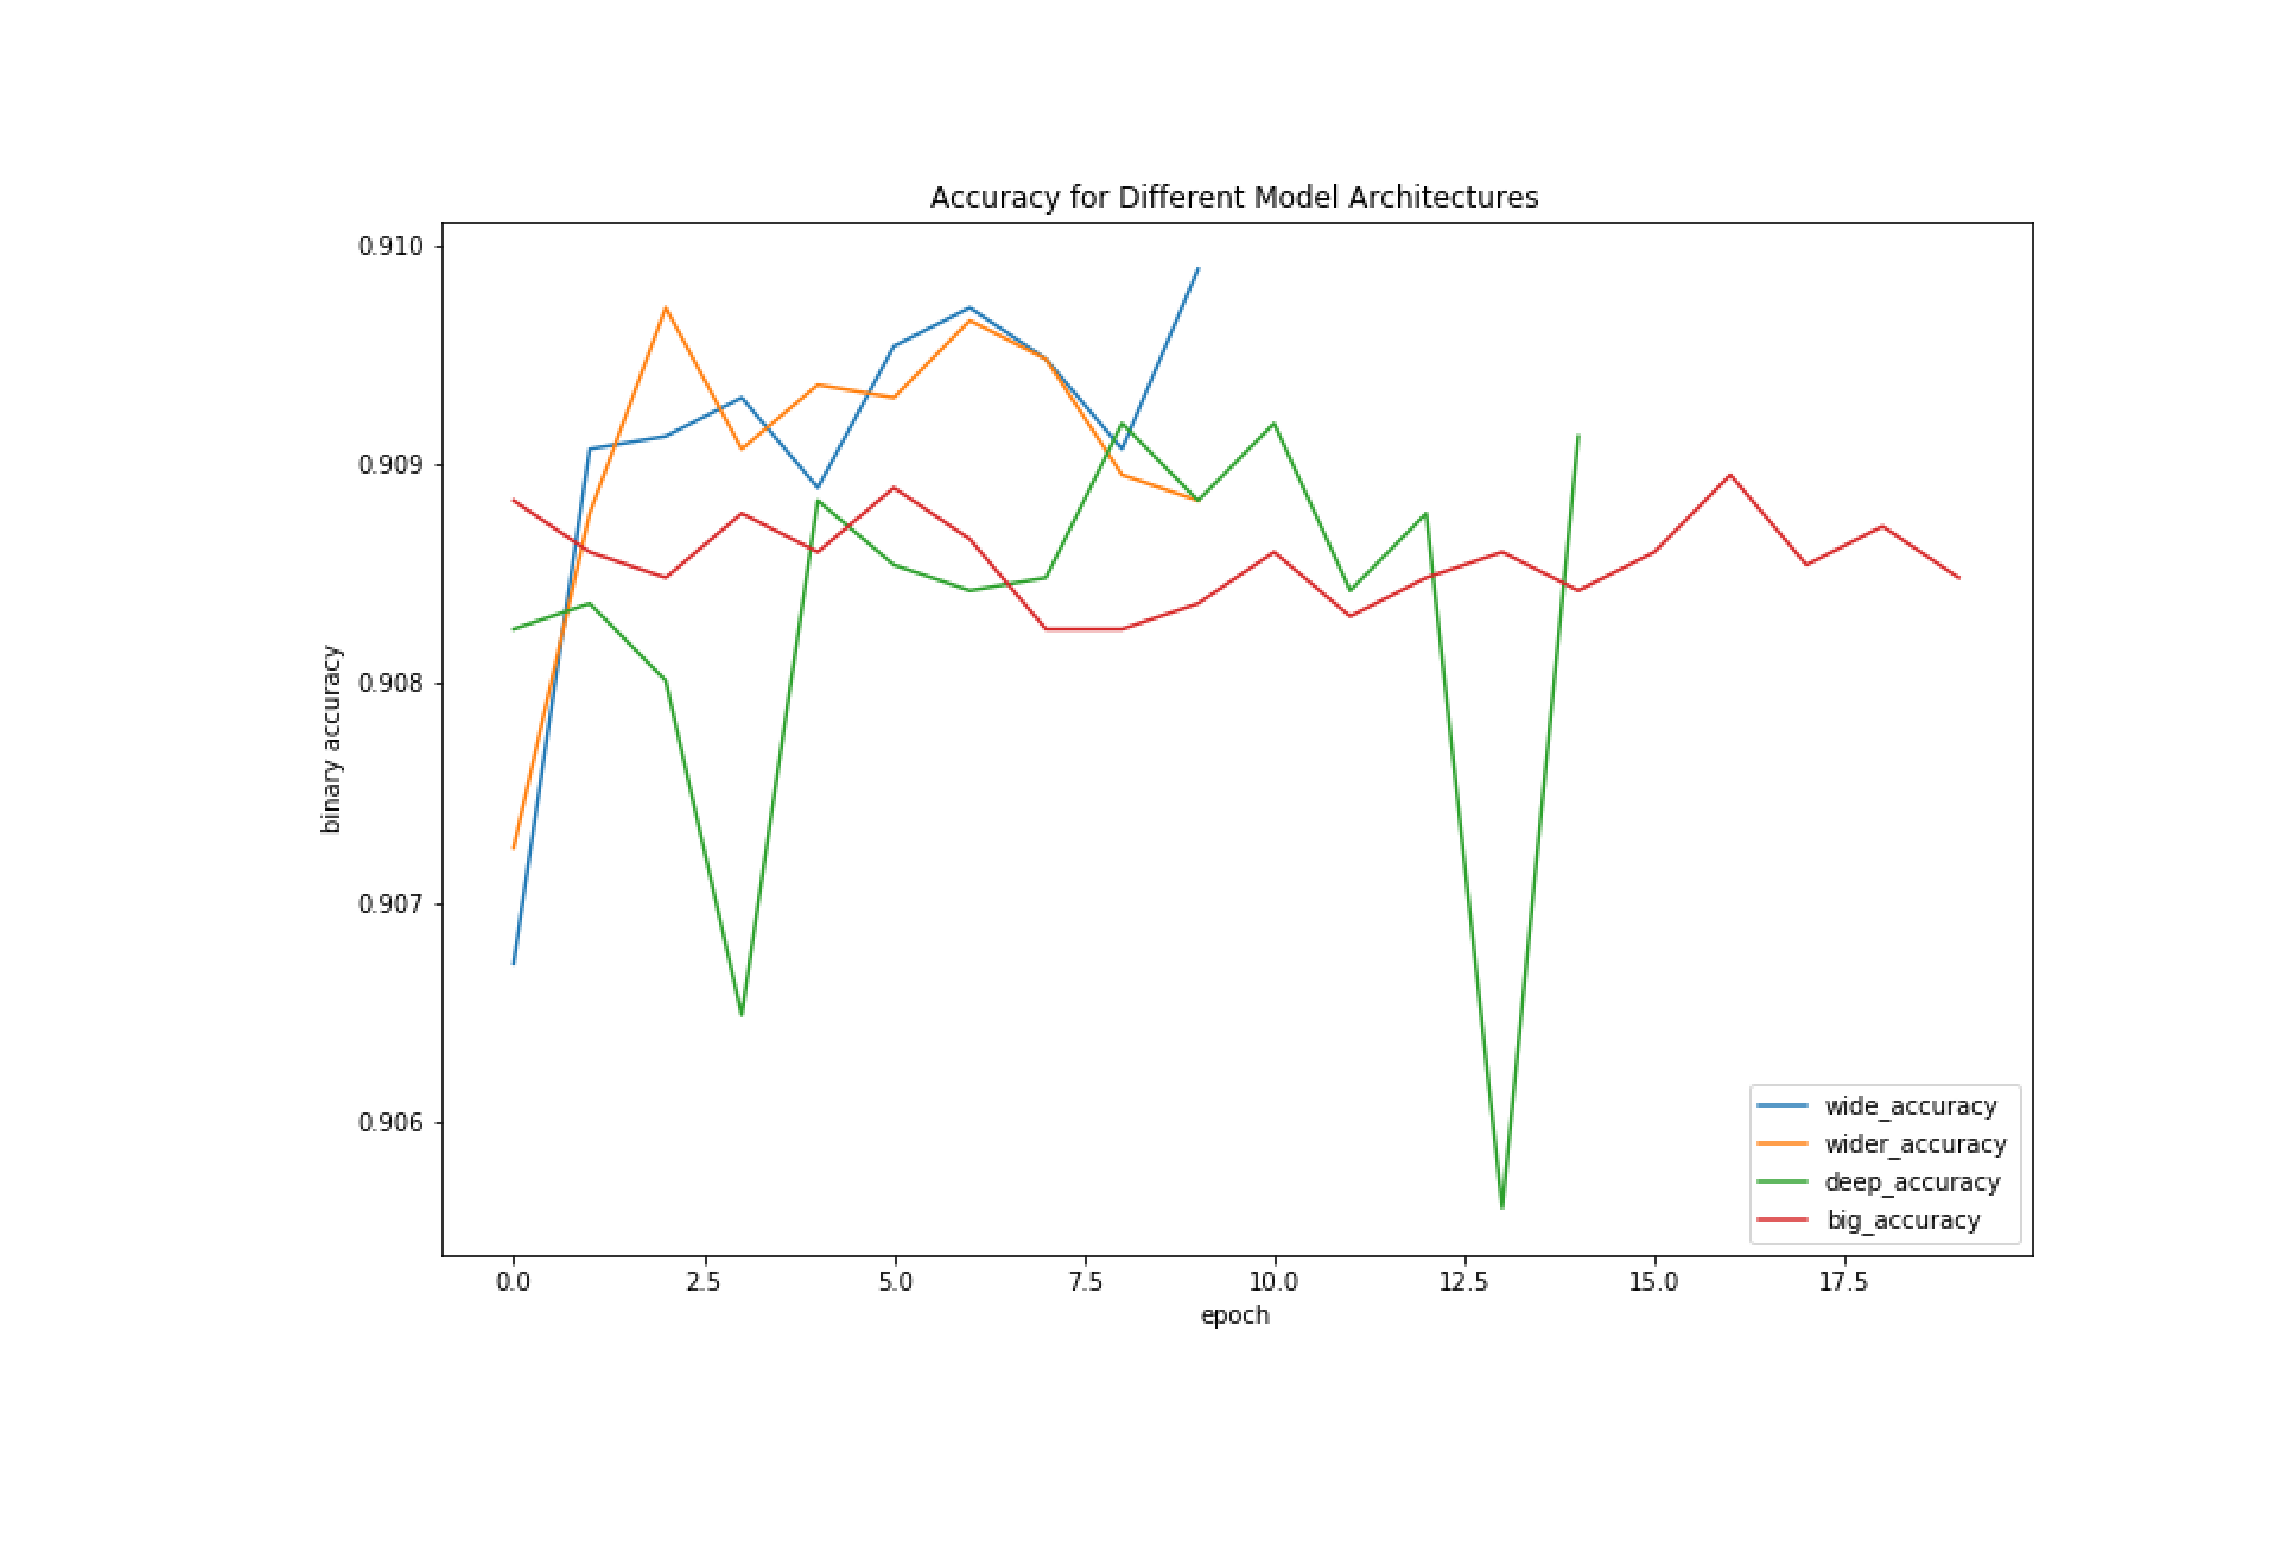

In [17]:
display_image('figures/neural_net_architectures.png')

We find that the big model has the most consistent performance, but overall the difference in performance between different architectures is negligible. 

Running the big model for 3 epochs gives the following ROC curve on the test set:

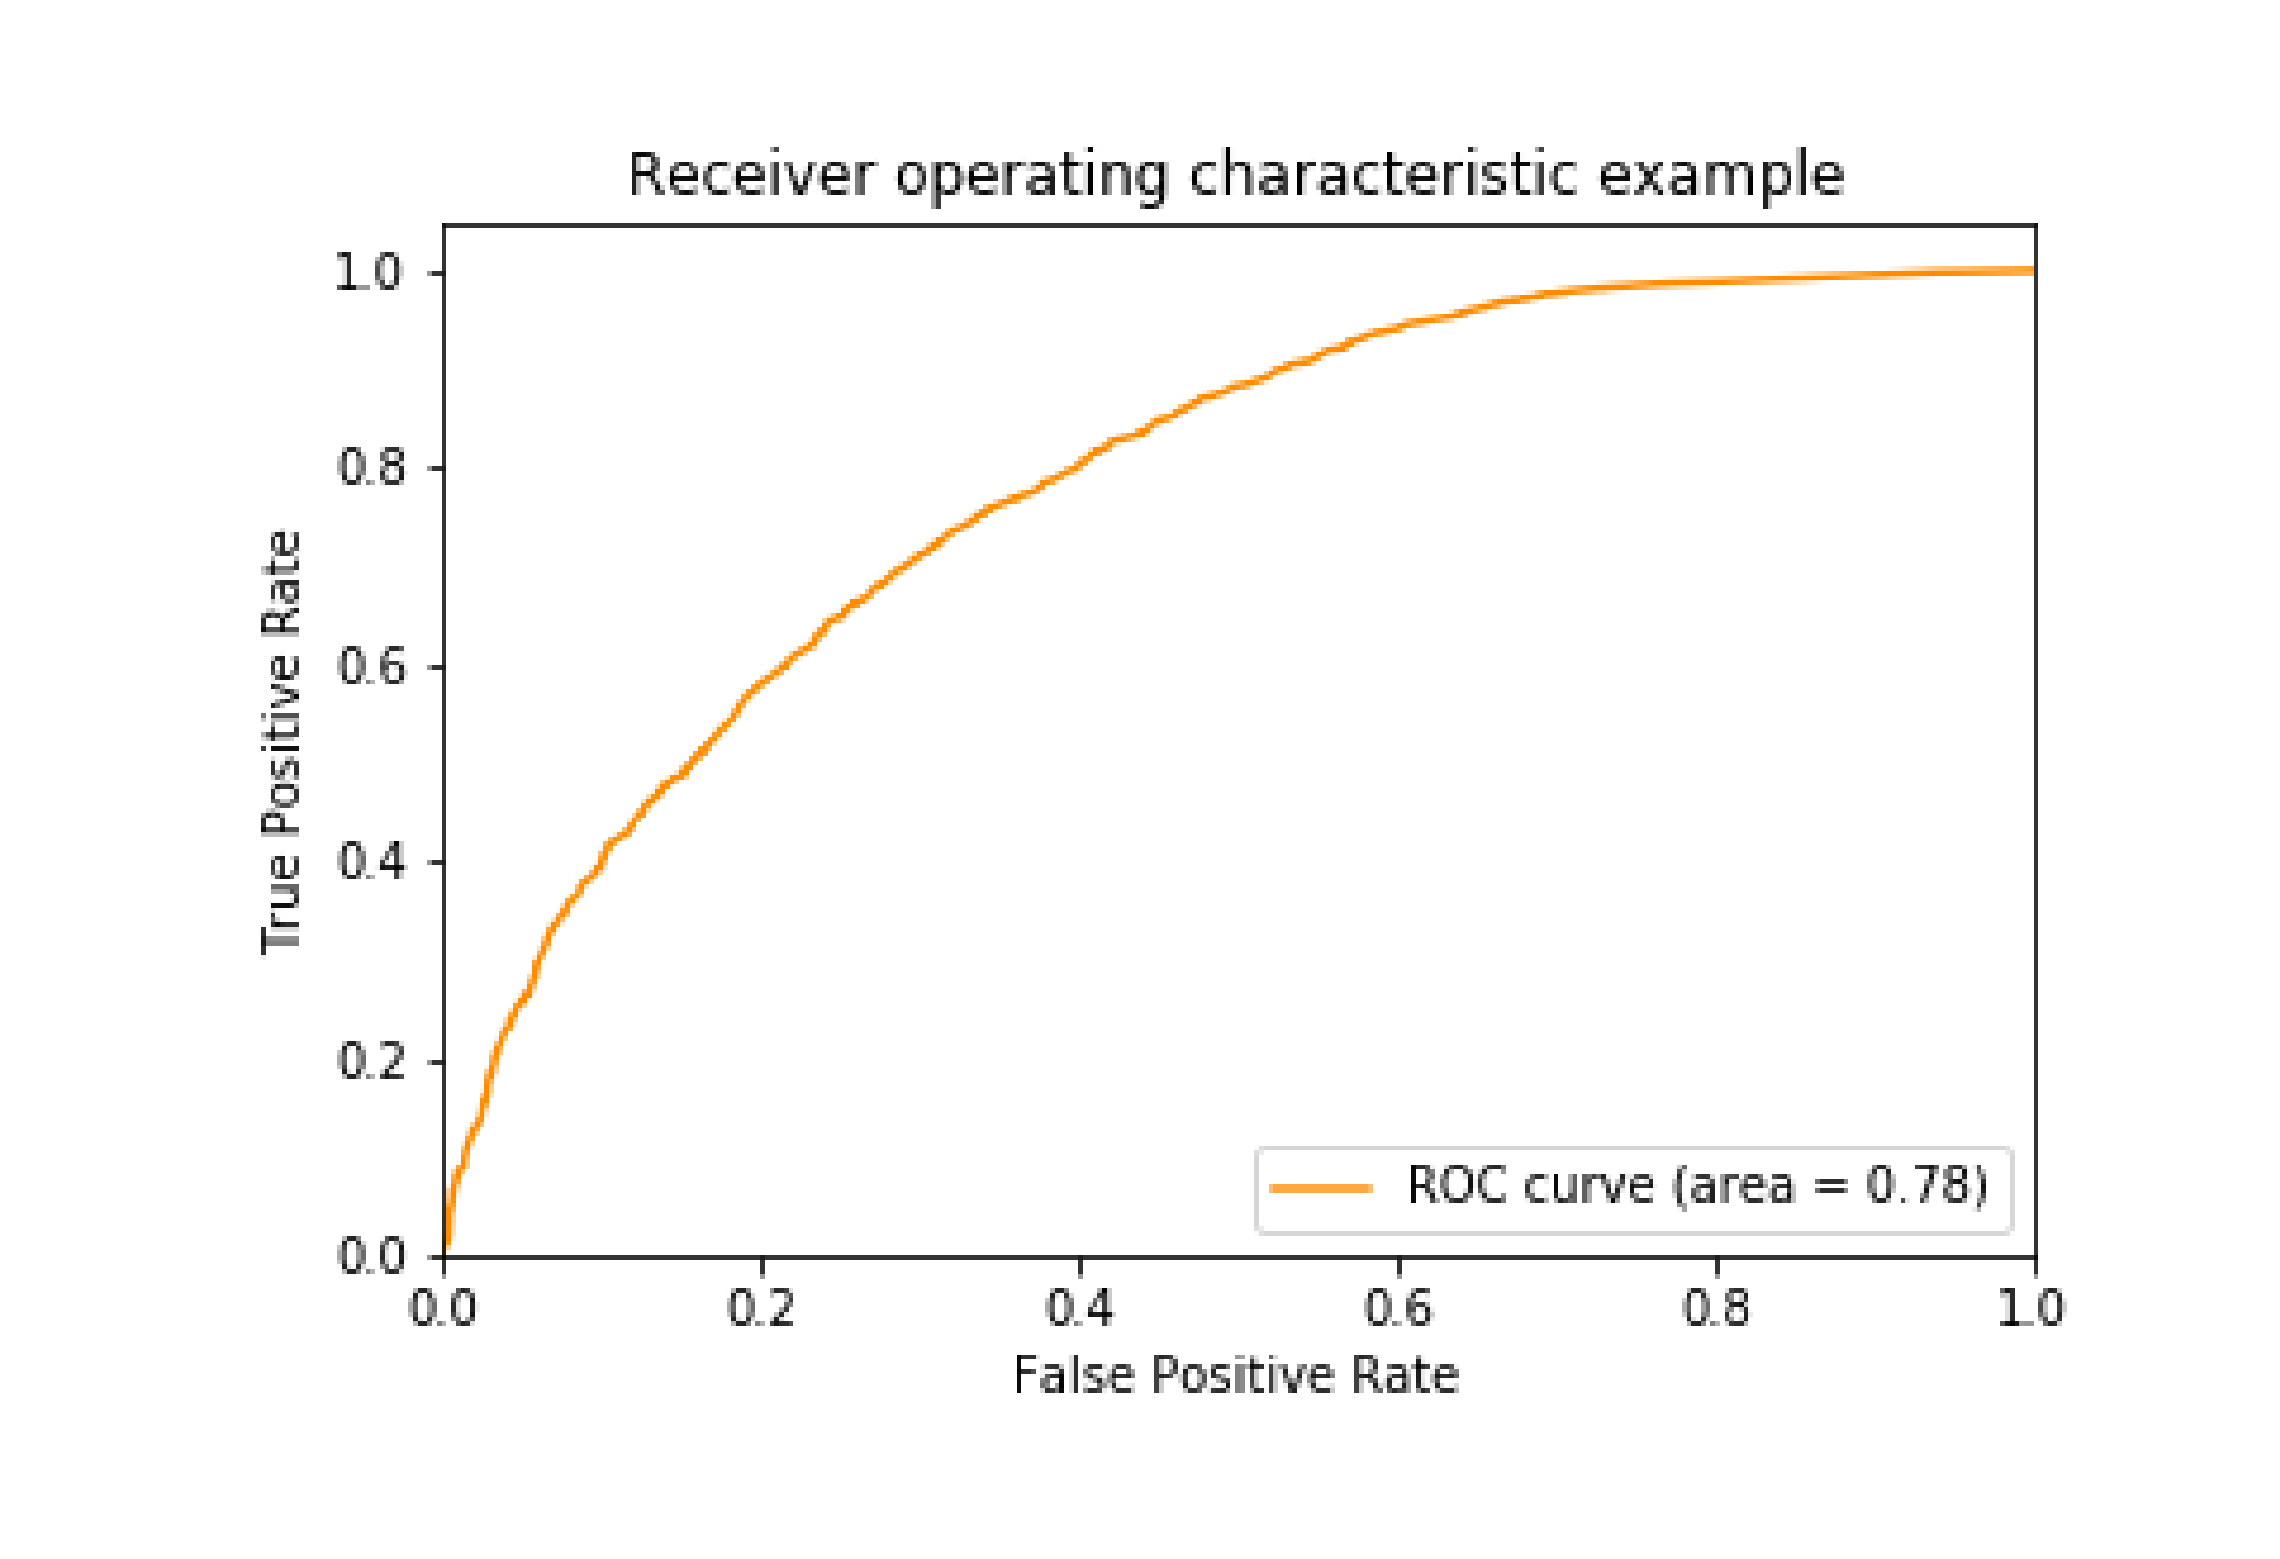

In [16]:
display_image('figures/NN_ROC.png')

The area under the ROC Curve indicates that this model performs better than the Lasso model. However, the binary accuracy at a true positive rate at 0.9 is only 0.85, which is identical to that of the Lasso model, meaning that at this sensitivity level the neural network fails to outperform the Lasso model.

## Random Forest

A **random forest** is an ensemble model which aggregates the predictions of one or more decision trees. A decision tree, in turn, is a classification model which can be represented as a series of yes-no decisions about individual features of a data vector. Each leaf of the tree is a class label corresponding to a prediction. For example, suppose a decision tree is fed some $\vec{x} \in \mathbb{R}^{2}$ and wants to predict if it is in class 1 or 2. It might do the following: 

1. Is $x_1 < 1.2$? If yes, go down the right branch. If no, go down the left branch. 
2. If $x_1 < 1.2$: Is $x_2 < 2.3$? If yes, $\vec{x}$ is in class 2. If not, $\vec{x}$ is in class 1. 
3. If $x_1 >= 1.2$: $\vec{x}$ is in class 1. 

Much like the verdant hills of North Berkeley, the random forests of machine learning have much to offer as a predictive model.

1. **Interpretability**: Unlike neural networks, whose behavior tends to be opaque, a decision tree is easily interpretable by humans. This is important for counterterrorism applications, since prediction is only an instrumental goal. The ultimate use of our project is to inform decision-makers about *what makes an attack successful.* Therefore, examining what features the decision trees in our model tend to split on is key to dispensing actionable advice to key actors, such as "weapon type is more important than target type."

2. **Ensemble modeling**: A random forest takes a weighted vote amongst various individual decision-tree classifiers, creating more robustness and allowing for hyperparamter optimization in the form of number of trees. 

3. **Binary classification**: Decision trees are well-suited to binary classification problems, which is the kind that we are trying to solve. In particular, we are trying to predict whether an attack will be successful or not. 

For details, see the notebook ```counter_terrorism_random_forest```.

### Grid Seach for Hyperparamter Optimization

When training the random forest model, we chose to perform **grid search** to optimize the hyperparameters of the model. While there are several hyperparameters in a random forest model which we could have searched over, we chose only two: 

1. **Maximum Depth**: This refers to the maximum allowable depth of each decision tree in the forest. Without a maximum depth, the trees would overfit by splitting until achieving perfect training accuracy. Therefore, it is important to keep maximum depth relatively small to avoid overfitting. 

2. **Number of estimators**: This refers to the number of decision trees in the forest. Presumably an increase in the number of trees increases robustness of the model. However, there is likely a point of diminishing marginal returns and perhaps even loss of test accuracy. 

For an impurity metric on splits, we chose the Gini Index. According to [research on the differences of these two methods](https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf), information gain and the Gini Index disagree in only 2 percent of cases, so this was likely not a significant decision (although it is another hyperparameter we might have optimized over). 

The cross-validation results of the hyperparameter search are below.

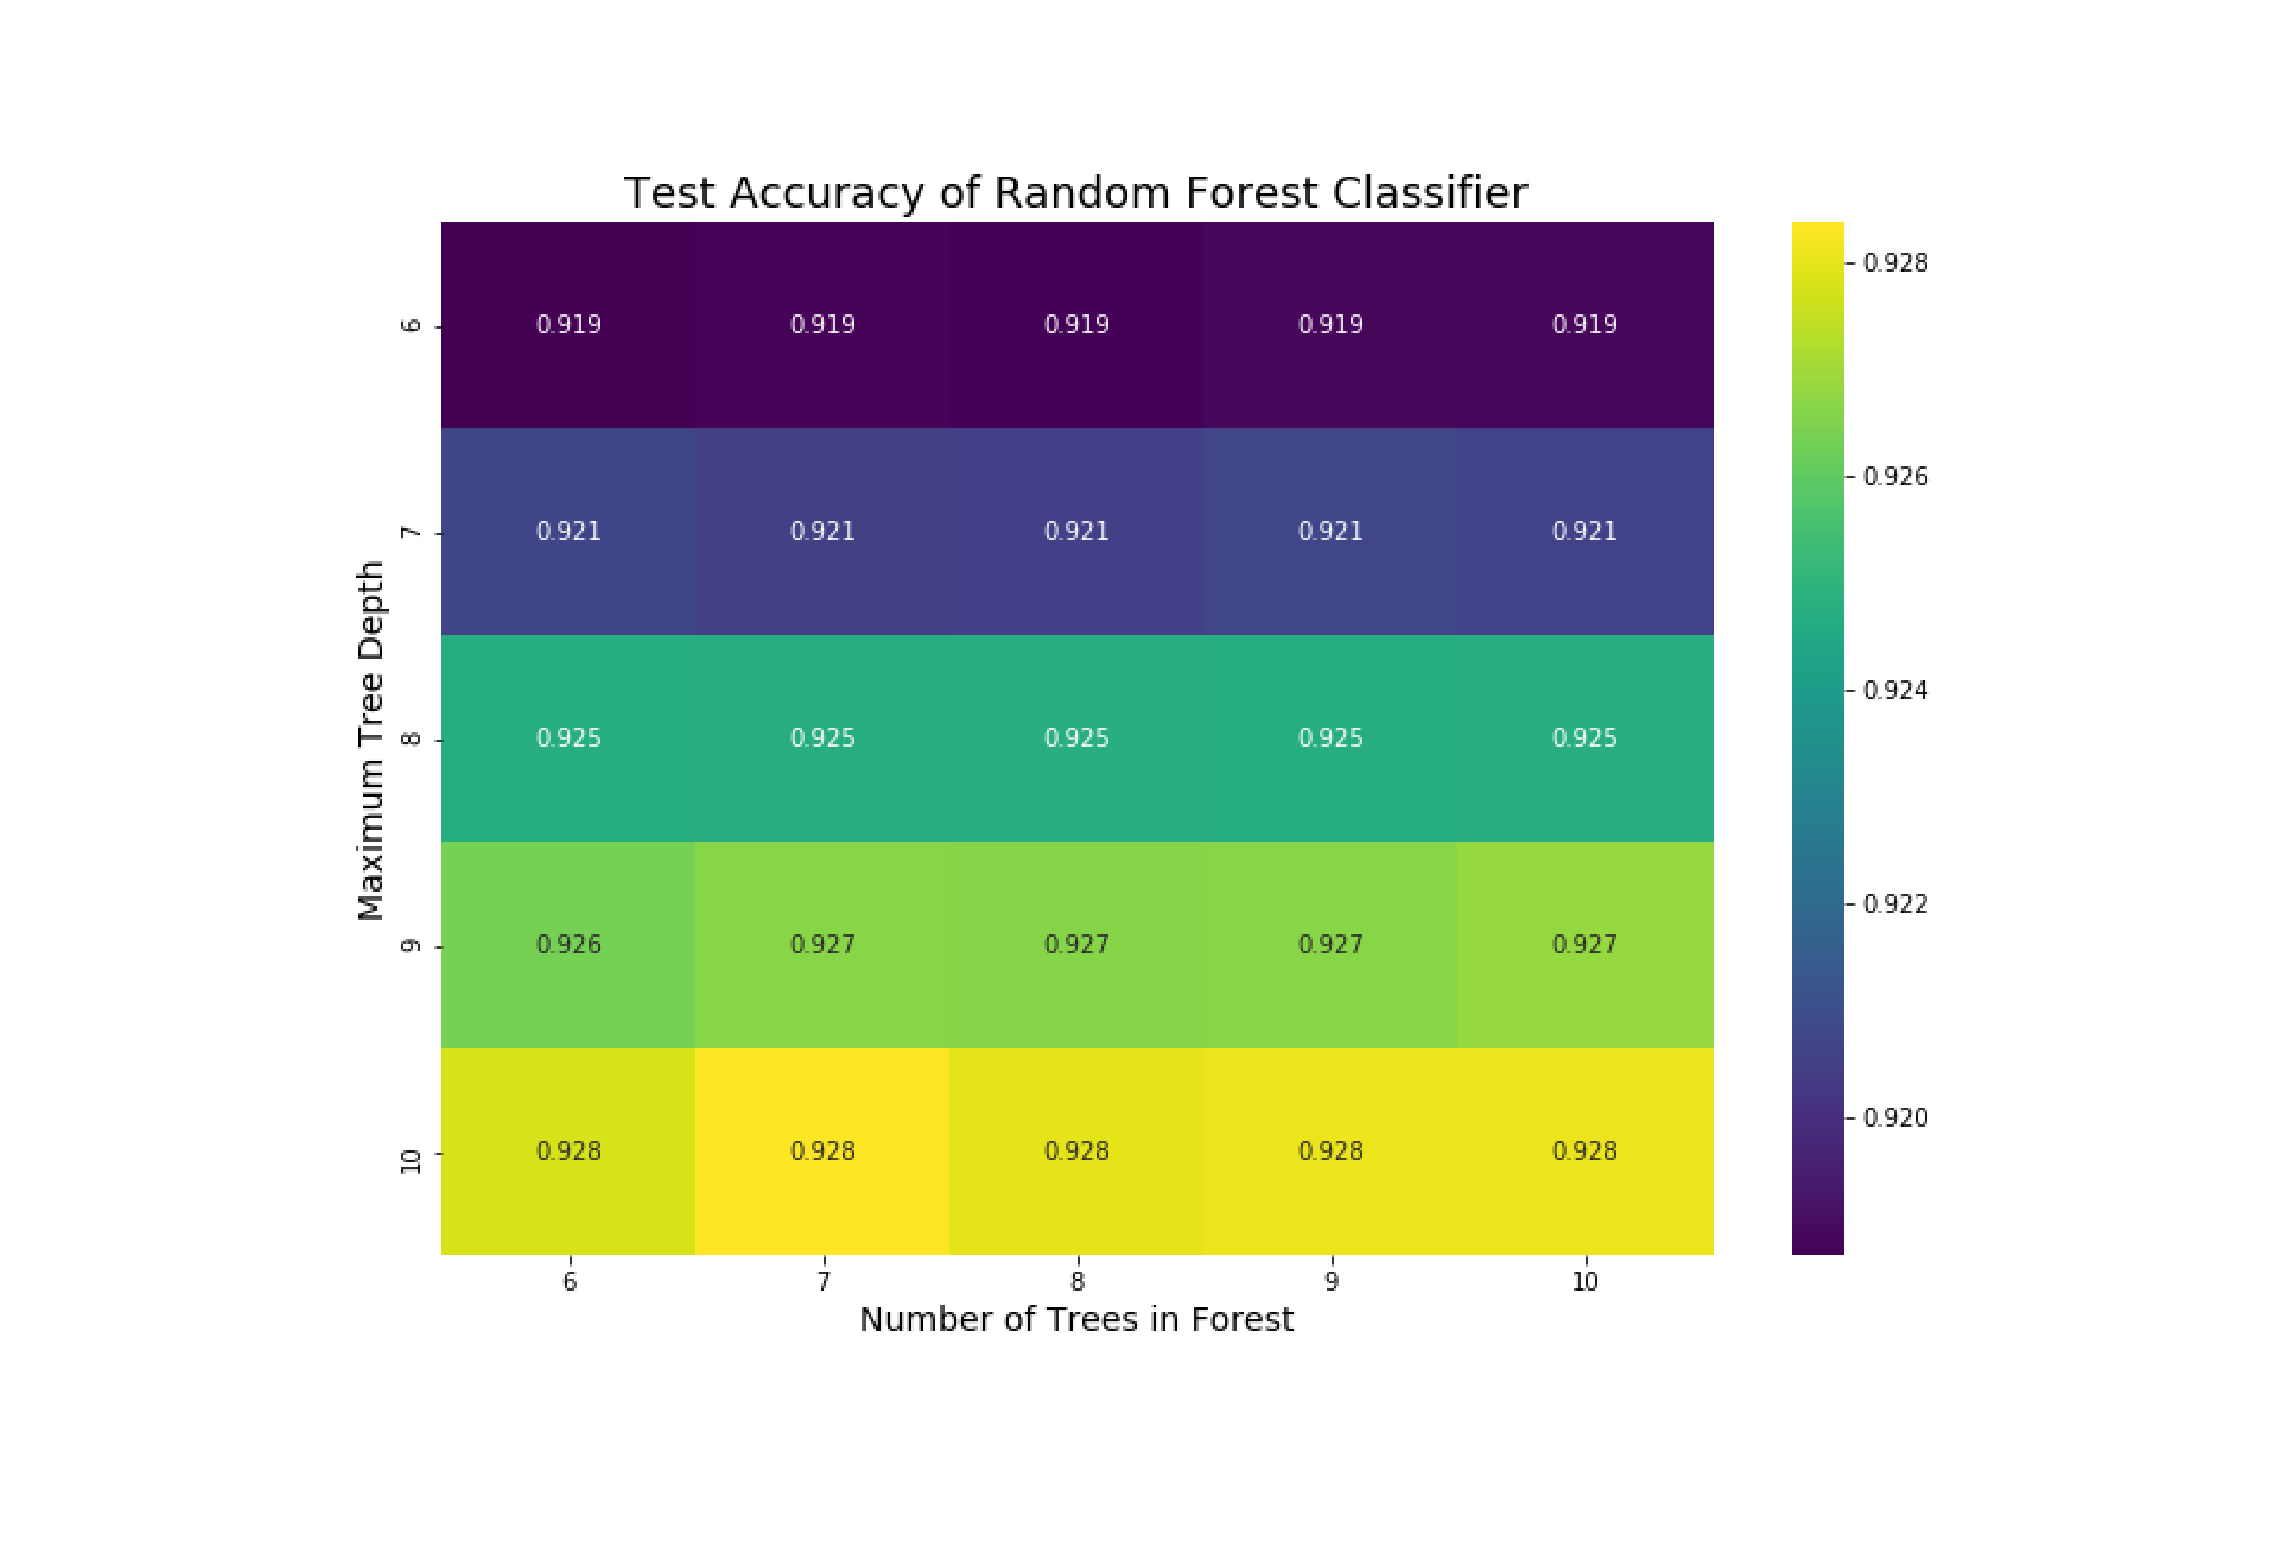

In [39]:
display_image('figures/random_forest_hyperparams_heatmap.png')

Notably, despite trying 25 different configurations, the best model performed only 1% better than the worst model. We hypothesize that this is due to the high salience of the few best features, which we suspect most of the random forest models chose to split on. This would explain their similar performance, since their most important high-level decision splits would be the same.

### Feature Salience

As discussed above, decision trees are easier to interpret than some other machine learning models due to their simple if-then control flow. A simple examination of which features the tree chooses to split on is informative, as it indicates what the tree thinks is "most predictive." This is espeically true when the depth of the tree is artificially constrained (in our case, to a depth of $10$), as this forces the tree to only use the most predictive features. 

Below, we display the most important features of the best random forest model: that with $7$ trees and a maximum depth of $10$. Note that while the numbers below should not be interpreted as percentages, the relative sizes and ordering of features by importance is meaningful.

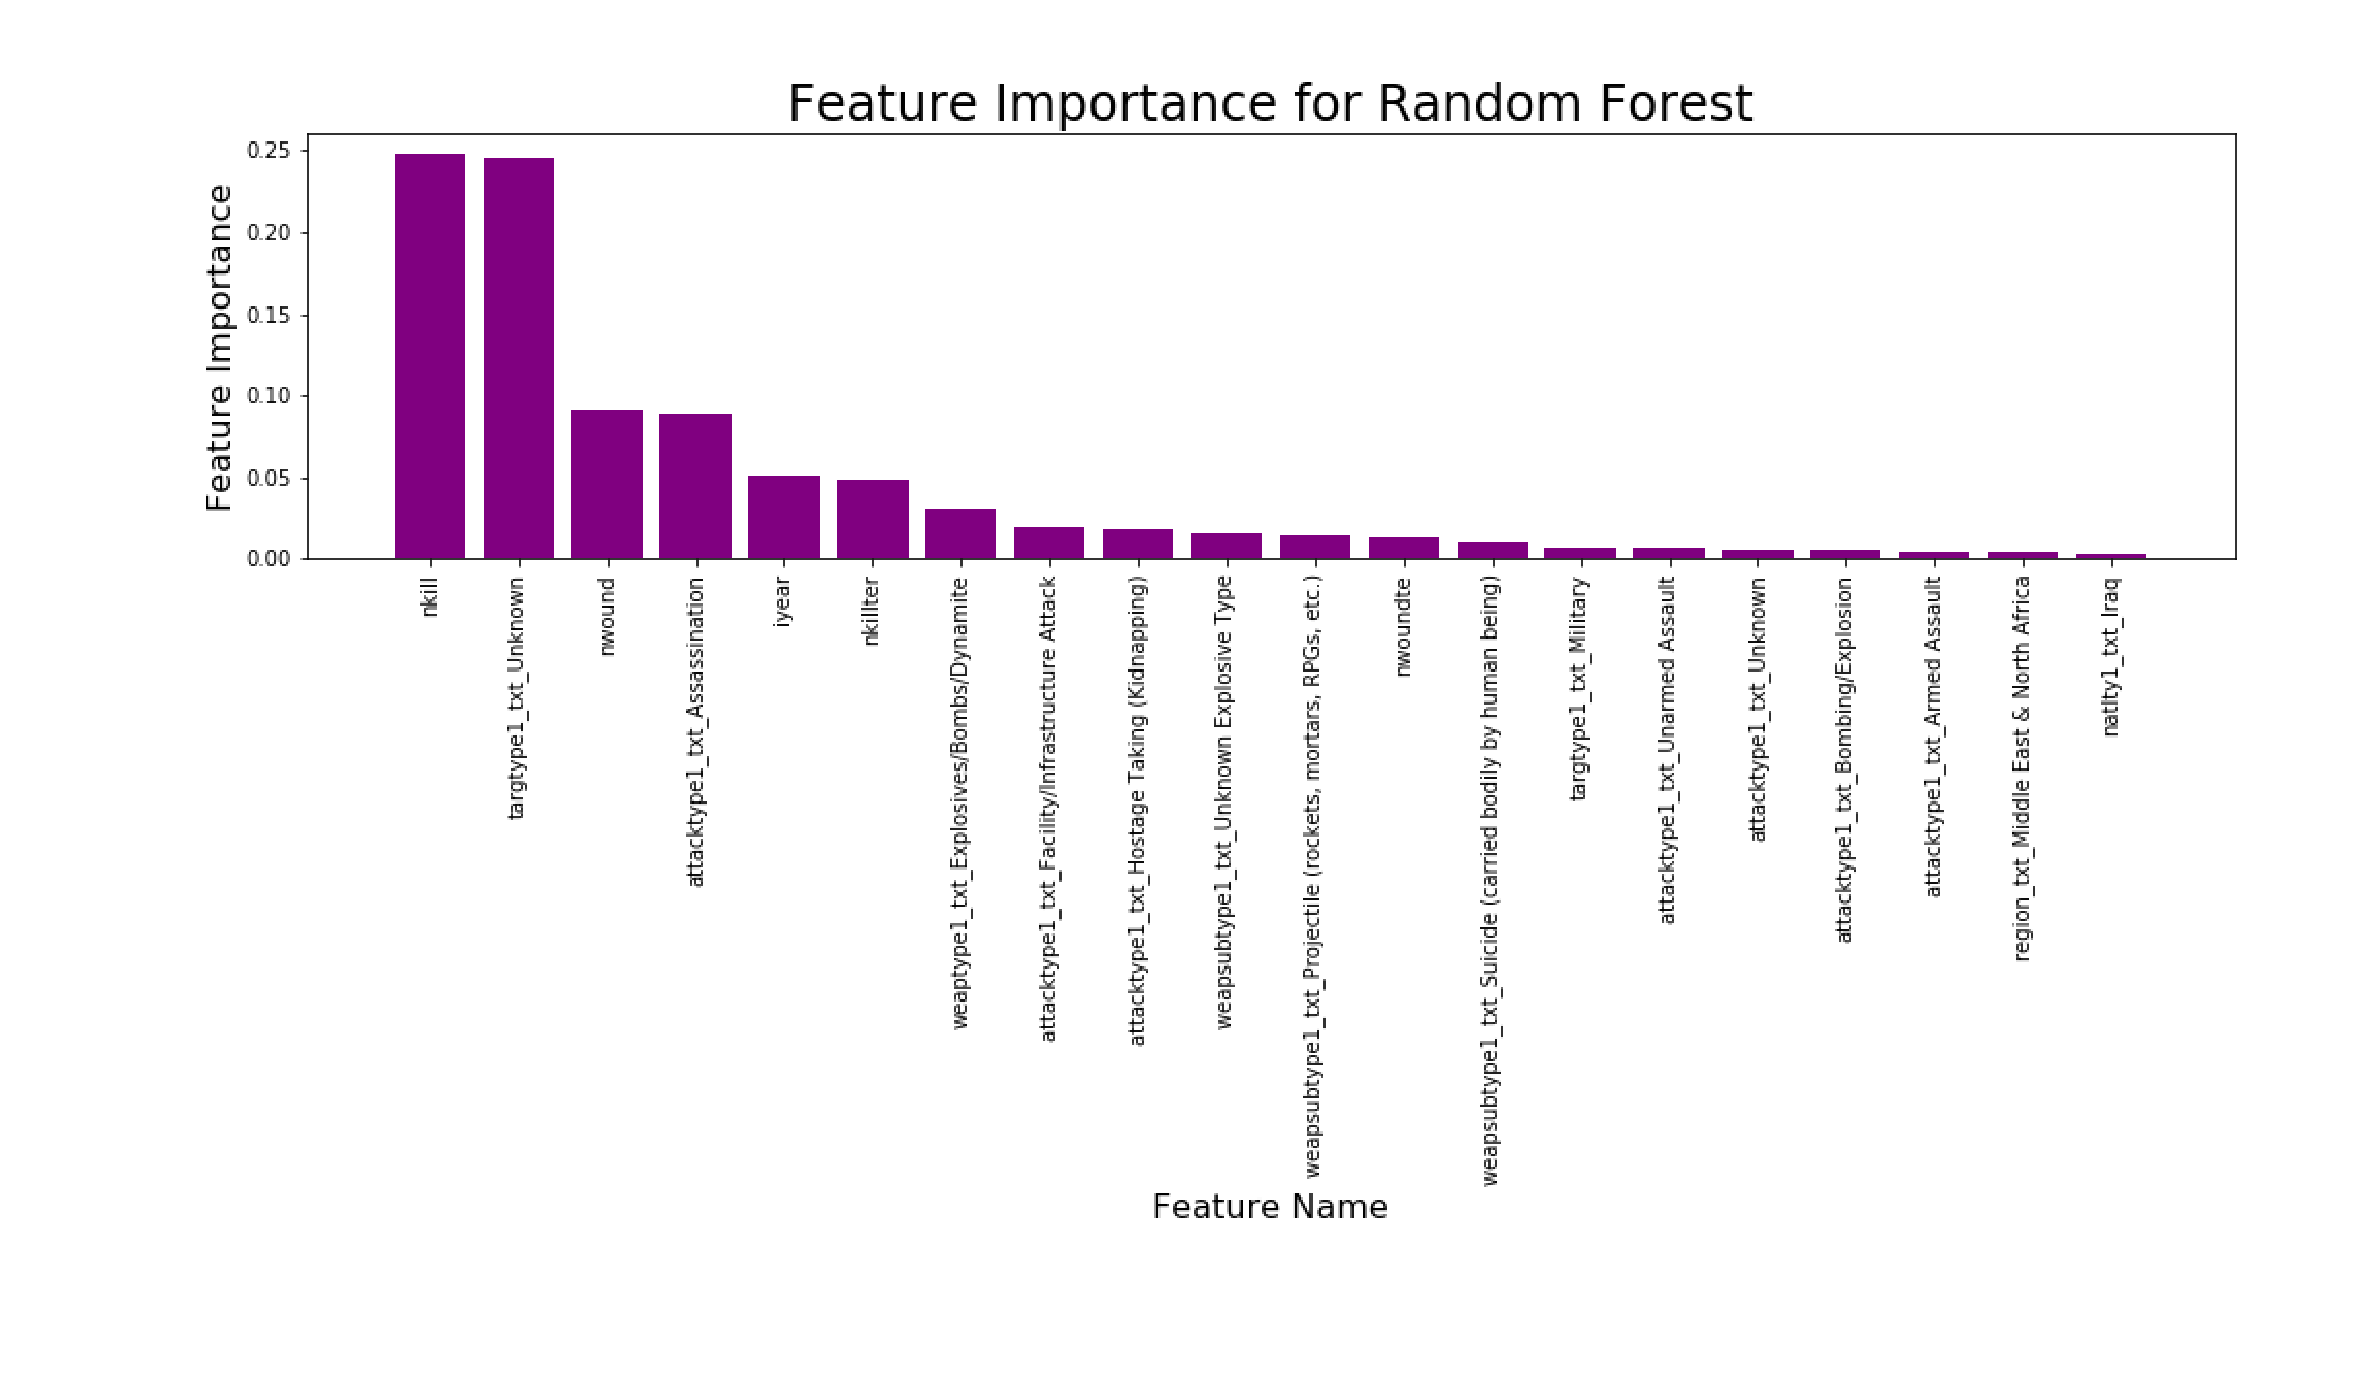

In [40]:
display_image('figures/random_forest_feature_importance.png')

The high salience of the top two features - number killed and unknown weapon type - might explain why adjusting hyperparameters did so little to change validation accuracy.

Unfortunately, the top 3 features by importance are things that are not realistically availabe in a predictive context - namely, number killed, number wounded, and 'unknown weapon type.' However, there are still some tentative conclusions we might be able to draw. In particular, the forest assigns high weight to knowing the weapon type and subtype used in the attack, so it is essential for counterterrorism teams to understand which weapons terrorists have access to. Further, it is important to understand the attack type (which is, of course, highly dependent on weapon type) as this is another common splitting feature. 

# Conclusion 

Our analysis illustrates the power of a data-driven approach to counterterrorism. While the problem of prediction is quite difficult, a quantitative approach yields impressive results, even with relatively simple models like ours. Moreover, we show that qualitative and quantitative methods, far from being in conflict, actually complement each other. Qualitatitive insight informs model choices and the crafting of data, but quantitative insight and analysis of trends can help to generate these qualitatitive understandings as well. 

There are several avenues for subsequent analysis, a few of which we will mention here. First, a different selection of features or data representation might yield signficantly different results. Second, predictions on different variables, such as number of people killed, might result in a prioritization of different features. Third, unsupervised learning methods such as clustering or dimensionality reduction might find useful relationships between terrorist groups, weapon types, attack types, or other features. While these are not directly relevant to the problem of prediction, they nevertheless have the potential to uncover relationships previously unknown - a task especially suited to terrorist networks, which tend to be fluid and vaguely defined. Finally, the introduction of additional information, such as demographic or economic data, opens the door to additional depth in all of these methods. 

# Appendices

## Acknowledgments

The authors would like to thank Professor Fernando Perez and our GSI Eli Ben-Michael for their guidance and mentorship. We thoroughly enjoyed the course and appreciated the opportunity to explore this rich and interesting dataset with the skills we learned in Statistical and Collaborative Data Science.

## Work Division

The division of labor for this project was roughly as follows:
- Yakub: Visualizations for attack locations and trends over time
- Paul: Neural Network and Lasso Predictions
- Akhil: Affinity Maps and Decision Trees 

We collaborated heavily and all wrote in the main notebooks, in addition to helping one another. 